In [1]:
import os
os.environ['R_HOME'] = '/Users/nathanielnyema/opt/anaconda3/envs/fnc/lib/R'
import rpy2
from utils import *
import pingouin as pg
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.anova import AnovaRM
import statsmodels.api as sm
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
from concurrent.futures import ThreadPoolExecutor, as_completed
# get some functions for the behavior analyses
import sys
sys.path.append('../behavior')
from fnc_analysis import (two_bottle_plot, cumm_test_licks_plot, check_significance,
                          two_bottle_pref_plot_vl, plot_significance)
from concurrent.futures import ThreadPoolExecutor, as_completed

%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython


In [2]:
%%R
library(lme4)
library(lmerTest)
library(splines)


R[write to console]: Loading required package: Matrix

R[write to console]: 
Attaching package: ‘lmerTest’


R[write to console]: The following object is masked from ‘package:lme4’:

    lmer


R[write to console]: The following object is masked from ‘package:stats’:

    step




In [3]:
#figure settings
mpl.rcParams['axes.prop_cycle'] = plt.cycler(color = sns.color_palette('Set1',10))
mpl.rcParams['svg.fonttype'] = 'none'

In [4]:
# figure save paths
first_lick_pdfs = os.path.join('figures', 'training', 'full-trace', 'first-lick', 'pdfs')
first_lick_svgs = os.path.join('figures', 'training', 'full-trace', 'first-lick', 'svgs')

peri_stim_pdfs_train =  os.path.join('figures', 'training', 'peri-stim', 'pdfs')
peri_stim_svgs_train =  os.path.join('figures', 'training', 'peri-stim', 'svgs')
peri_stim_train_figs =  os.path.join('figures', 'training', 'peri-stim')

peri_stim_pdfs_test = os.path.join('figures', 'testing', 'peri-stim', 'pdfs')
peri_stim_svgs_test = os.path.join('figures', 'testing', 'peri-stim', 'svgs')
peri_stim_test_figs = os.path.join('figures', 'testing', 'peri-stim')

first_lick_test_pdfs = os.path.join('figures', 'testing', 'full-trace', 'pdfs')
first_lick_test_svgs =  os.path.join('figures', 'testing', 'full-trace',  'svgs')

methods_pdfs = os.path.join('figures', 'methods', 'pdfs')
methods_svgs = os.path.join('figures', 'methods', 'svgs')

fig_paths = [ first_lick_pdfs, first_lick_svgs,
              peri_stim_train_figs,
              peri_stim_pdfs_train, peri_stim_svgs_train,
              peri_stim_test_figs,
              peri_stim_pdfs_test, peri_stim_svgs_test,
              first_lick_test_pdfs, first_lick_test_svgs,
              methods_pdfs, methods_svgs ]

for i in fig_paths:
    os.makedirs(i, exist_ok=True)         


main_train_fig_stats = {}
main_test_fig_stats = {}

cohort1_data_dir = Path("../../data/photometry/cohort1")
cohort2_data_dir = Path("../../data/photometry/cohort2")
data_dir = Path("../../data/photometry")

In [5]:
# analysis parameters
# preprocessing
ds_freq = 10                              # frequency to downsample to
ex = 10                                   # number of standard deviations beyond which to exclude data points (i.e. artifact)
t_dur = 1800                              # total duration of each session in seconds from spout presentation
norm_method = norm_to_median_pre_stim     # normalization method, see functions in the utilities file in  our photometry scripts
detrend = True                            # whether or not to regress out motion and photobleaching artifact using the 405
detrend_method = detrend_405_constrained  # method for artifact removal. constrained means we only regress out positive correlations between the 470 and 405


# peri-bout
bout_thresh = 20                          # inter-lick-interval threshold for defining a new bout
niters_rand = 100                         # number of iterations over which generate random bouts
peri_window = 15                          # duration in seconds flanking the bout onset to analyze peri-bout responses
peri_bout_norm_train = "none"             # method for normalizing peri-bout responses during training
peri_bout_norm_test  = "none"             # method for normalizing peri-bout responses during testing

# kernel parameters for moving average detrending
w_rad= 30
ksize = int(2* ds_freq * w_rad) + 1
kernel = signal.boxcar(ksize)/ksize

# Training

## load data

In [6]:
# # load training data
training = analysis(norm_method, t_dur, 
                    ds_freq = 1, ex = ex, detrend = detrend, 
                    detrend_method = detrend_method)
training.load_append_save(cohort1_data_dir/'training.npy')
training.load_append_save(cohort2_data_dir/'training.npy')
training.remove_mouse('adm480')

loading data from file...
loading data from file...


/Users/nathanielnyema/Downloads/photometry-scripts/analysis_pipeline.py:408: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.excluded_raw.append(self.raw_data.xs(pd.IndexSlice[:,mouse], drop_level=False))


recomputing...


/Users/nathanielnyema/Downloads/photometry-scripts/utilities.py:246: RuntimeWarning: invalid value encountered in divide
  normed_405 = (data.F405 - f405_baseline)/f405_baseline
/Users/nathanielnyema/Downloads/photometry-scripts/utilities.py:246: RuntimeWarning: invalid value encountered in divide
  normed_405 = (data.F405 - f405_baseline)/f405_baseline
/Users/nathanielnyema/Downloads/photometry-scripts/utilities.py:246: RuntimeWarning: invalid value encountered in divide
  normed_405 = (data.F405 - f405_baseline)/f405_baseline


successful


/Users/nathanielnyema/Downloads/photometry-scripts/analysis_pipeline.py:326: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.err_490=self.all_490.groupby('cond',axis=1).sem()
/Users/nathanielnyema/Downloads/photometry-scripts/analysis_pipeline.py:330: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.err_405=self.all_405.groupby('cond',axis=1).sem()


## some methods plots

### rationale for our constrained detrending method

It's important to remember that the 405 is not exactly the isosbestic point for GCAMP. As a result, it's fairly common for very drastic responses to see calcium dependent deflections in the 405 in the opposite direction of the GCAMP response. AgRP responses are typically quite drastic so this is fairly common in mice with good signal as illustrated below. It's important we are aware of this because the standard procedure for using the 405 to detrend the 490 makes the assumption that any correlation between the 405 and 490 is artifact, when in fact the 405 and 490 will be strongly negatively correlated for strong AgRP response. Another way to think about this is to recognize that when these calcium dependent deflections occur in the 405, one could feasible multiply the 405 by a very negative coefficient and reconstruct the 490 almost exactly. As a result when you fit the 405 to the 490 to obtain a baseline to subtract from the signal, you almost certainly will subtract away a majority of the response. 

In [7]:
# #note we're using the data that's already been normalized for demonstration purposes
# raw = deepcopy(training.raw_data.loc['training_3_pm','adm556',0])
# raw.center_stim()
# raw.resample(training.t)

# fig, ax = plt.subplots(2,2, figsize = (8,8))

# f4 = raw.F490
# f5 = raw.F405
# ax[0,0].plot(raw.t, 10*f5, label = 'scaled 405')
# ax[0,0].plot(raw.t, f4, label = '465')
# ax[0,0].legend()
# ax[0,0].set_ylabel('output [mV]')
# ax[0,0].set_xlabel('time [s]')


# ax[0,1].scatter(f5, f4)
# ax[0,1].set_xlabel('405')
# ax[0,1].set_ylabel('465')


# m,b = np.polyfit(f5, f4, 1)
# ax[0,1].plot(np.sort(f5), m*np.sort(f5) + b, c = 'k')

# base = pd.Series(gaussian_filter1d(m*f5 + b, sigma = 20), index = raw.t)
# base -= np.median(base.loc[:0])
# ax[1,0].plot(raw.t, f4,  label = 'raw 465')
# ax[1,0].plot(raw.t, base, label = 'baseline')
# ax[1,0].set_ylabel('output [mV]')
# ax[1,0].set_xlabel('time [s]')


# ax[1,1].plot(raw.t, (raw.F490 - np.median(raw[:0].F490))/np.median(raw[:0].F490), label = 'no detrending')
# raw.F490 =  f4 -base
# ax[1,1].plot(raw.t, (raw.F490 - np.median(raw[:0].F490))/np.median(raw[:0].F490), label = 'with detrending')
# ax[1,1].set_ylabel(r"$\frac{\Delta F}{F}$")
# ax[1,1].set_xlabel(r"time [s]")
# sns.despine()
# fig.tight_layout(pad=1.)
# fig.savefig(os.path.join('figures', 'methods', 'pdfs', 'detrending_405.pdf'))
# fig.savefig(os.path.join('figures', 'methods', 'svgs', 'detrending_405.svg'))

### lickometer validation

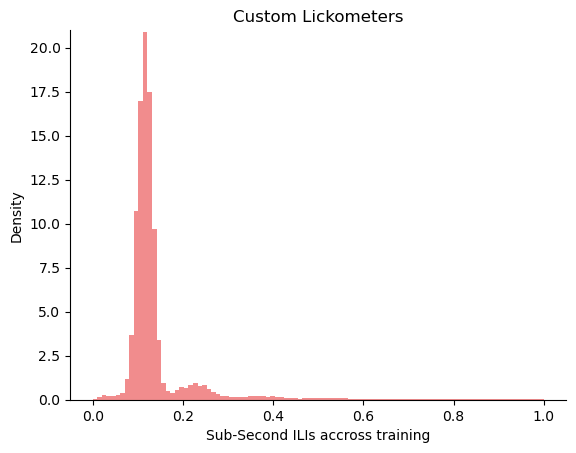

In [8]:
f = np.array([])
for i in training.raw_data:
    c = i.events['left_licks']
    c=(c[1:]-c[:-1])
    f=np.concatenate((f,c))
plt.hist(f[f<1], np.linspace(0,1, 100), alpha=.5, density = True);
plt.xlabel('Sub-Second ILIs accross training')
plt.ylabel('Density')
plt.title('Custom Lickometers')
plt.ylim(0,21)
sns.despine()

plt.savefig(os.path.join('figures', 'methods', 'pdfs', 'ili_resolutin_benchmark_custom.pdf'))
plt.savefig(os.path.join('figures', 'methods', 'svgs', 'ili_resolutin_benchmark_custom.svg'))

## Bulk analysis

In [9]:
# time lock to first lick
first_lick = time_lock_lick(training, 0)

/Users/nathanielnyema/Downloads/fnc_agrp_project/analysis/photometry/utils.py:206: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  a.err_490 = tmp.groupby('cond', axis = 1).sem()
/Users/nathanielnyema/Downloads/fnc_agrp_project/analysis/photometry/utils.py:211: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  a.err_405 = tmp2.groupby('cond', axis = 1).sem()


### plot time lock mean traces

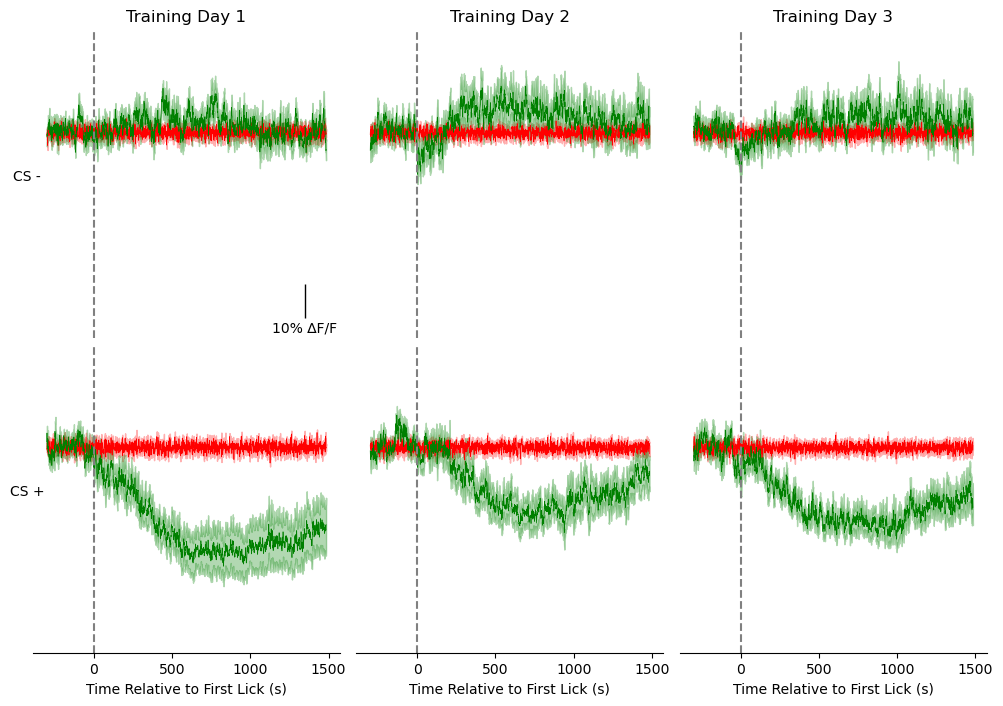

In [10]:
# let's plot both the 470 and 405 for all sessions
fig,ax = plt.subplots(2,3, figsize = (10,7))
ylim = (-.6, .3)

# plot cs- sessions
for i,v in enumerate(cs['-']):
    first_lick.plot_both(cond = v, ax=ax[0,i], 
                       show=False, scale=1, c490 = 'g')
    ax[0,i].set( xlabel = '', ylabel = '',
                 title = f'Training Day {i+1}', 
                 ylim = ylim)
    ax[0,i].axvline(0,ls='--',c='grey')
    ax[0,i].tick_params(left=False,bottom=False, 
                        labelleft=False,labelbottom=False)

    sns.despine(ax=ax[0,i], left = True, bottom = True)
    
# plot cs+ sessions
for i,v in enumerate(cs['+']):
    first_lick.plot_both(cond = v, ax=ax[1,i], 
                       show=False, scale=1, c490 = 'g')
    ax[1,i].set( xlabel = 'Time Relative to First Lick (s)',
                 ylim = ylim, ylabel = '')
    ax[1,i].axvline(0,ls='--',c='grey')
    ax[1,i].tick_params(left=False,labelleft=False)
    sns.despine(ax=ax[1,i], left = True)

ax[0,0].set_ylabel('CS -', rotation = 0)
ax[1,0].set_ylabel('CS +', rotation = 0)

# create a size bar so we can remove the axes
vertbar = AnchoredSizeBar(ax[0,0].transData,
                           1, '10% ∆F/F', 'lower right', 
                           pad=.1,
                           color='black',
                           frameon=False,
                           size_vertical=.1)
ax[0,0].add_artist(vertbar)

# format  the plot and show
fig.tight_layout(pad = .5)
plt.show()

# save the figure
fig.savefig( os.path.join(first_lick_pdfs, 'avg_training_first_lick.pdf') , transparent=True, bbox_inches='tight')
fig.savefig( os.path.join(first_lick_svgs, 'avg_training_first_lick.svg') , transparent=True, bbox_inches='tight')

### plot traces for each mouse

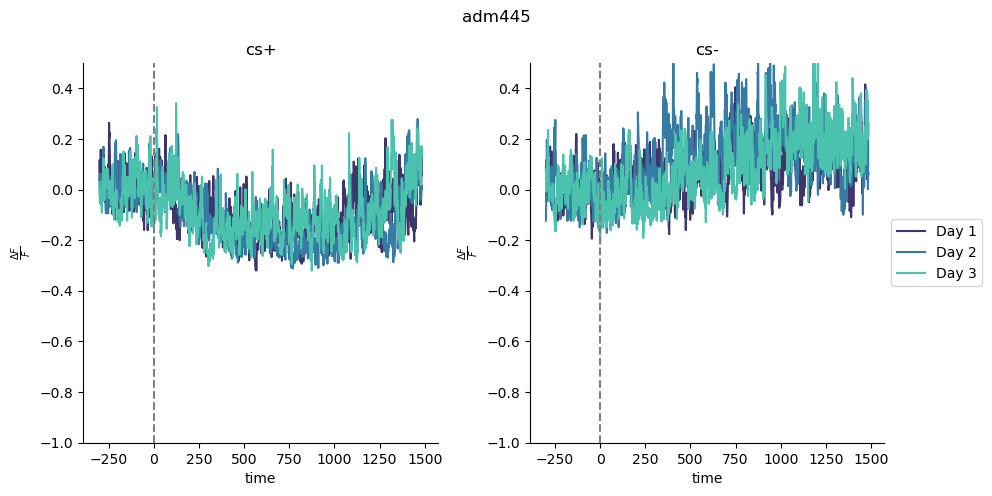

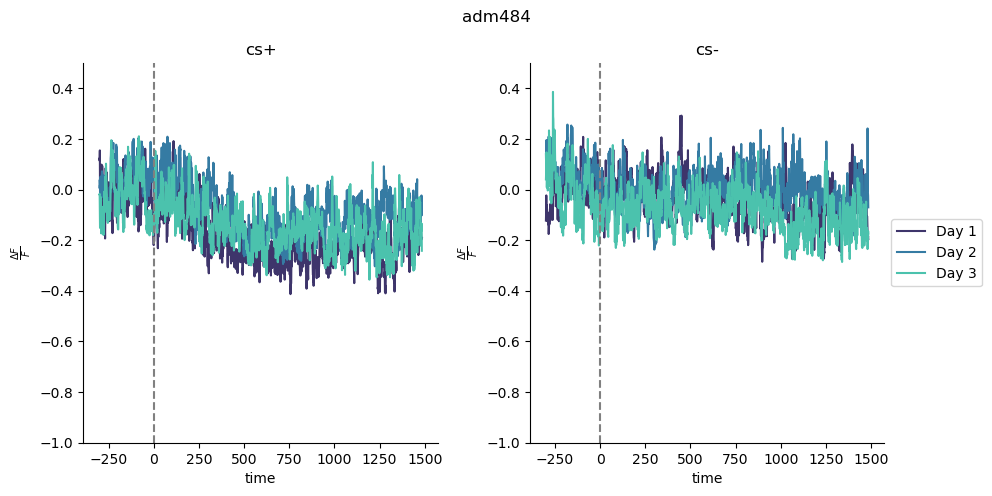

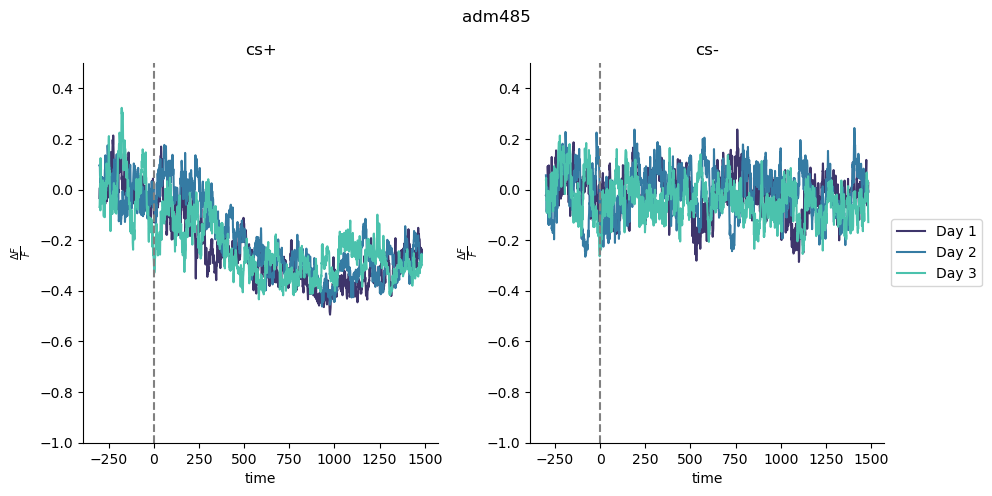

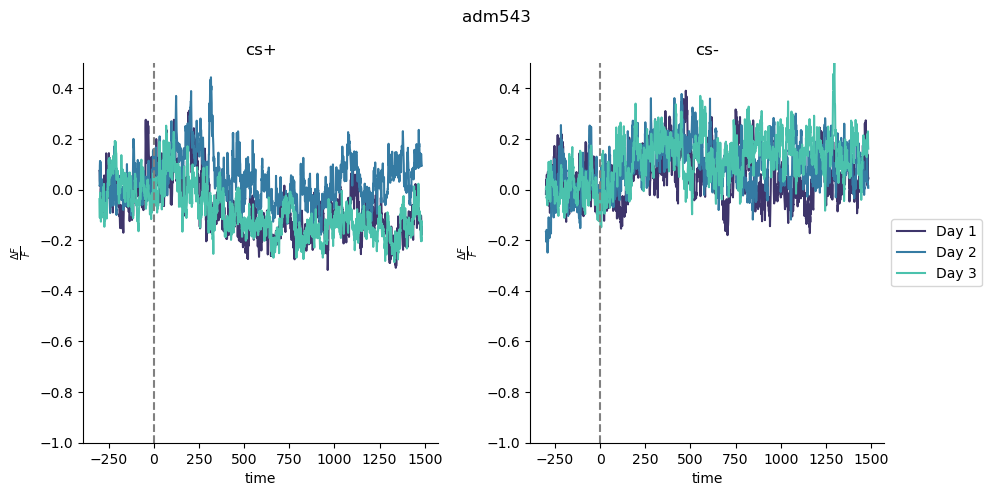

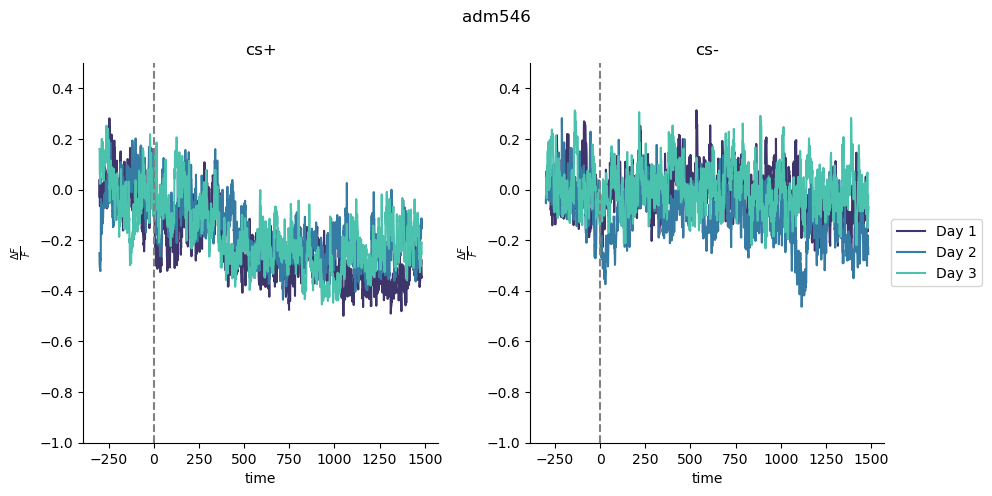

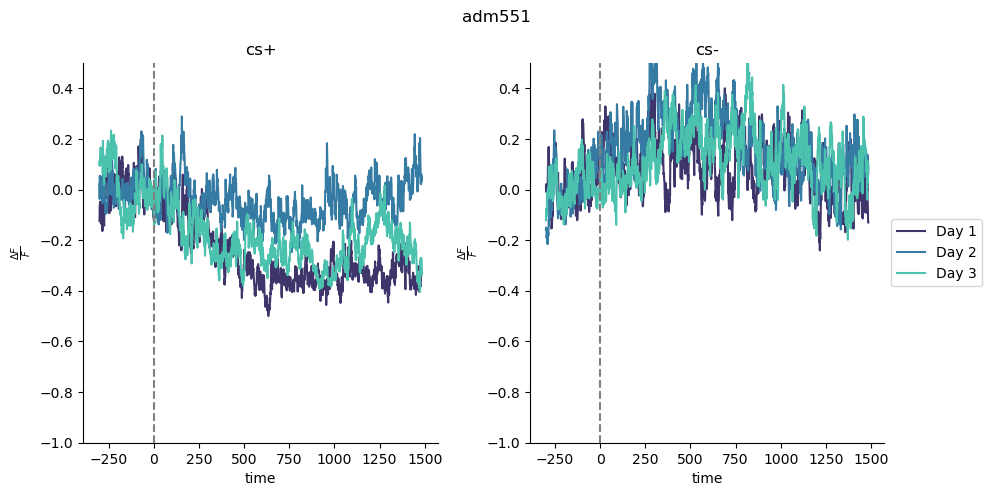

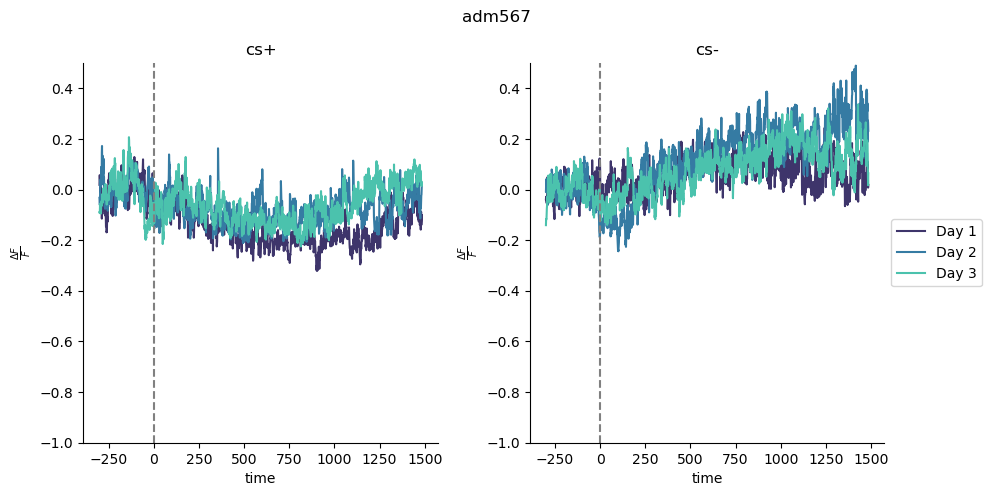

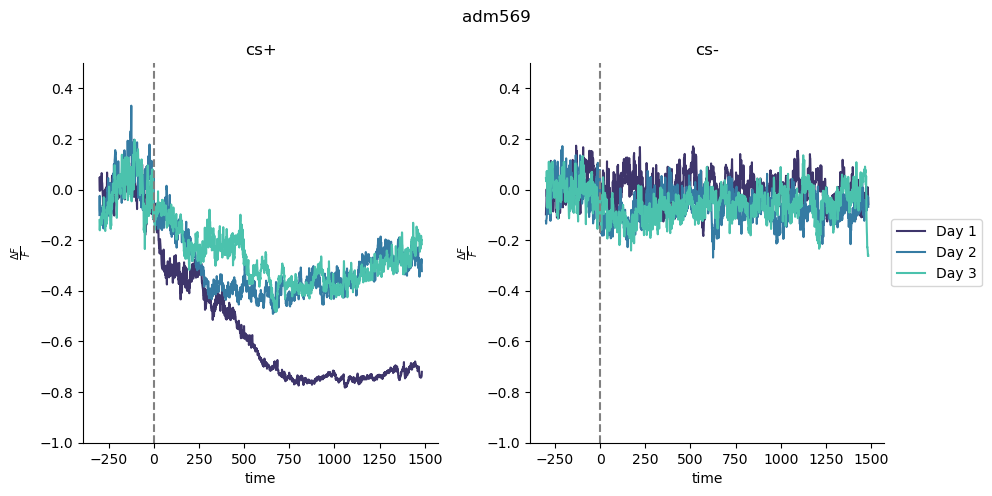

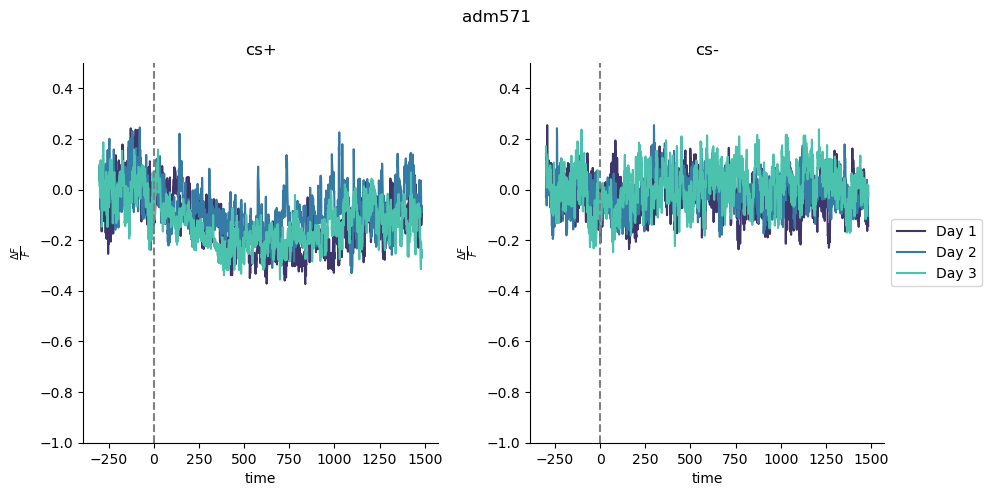

In [11]:
# # loop over the mice
for m in first_lick.mice:
    # create subplot
    fig,ax = plt.subplots(1,2, figsize = (10,5))
    
    # get mouse's cs+ licks
    tmp= first_lick.all_490.loc[:,cs['+']].loc[:,pd.IndexSlice[:,m]].droplevel('mouse', axis=1)
    tmp.index.set_names('time', inplace = True)
    tmp = tmp.stack().rename(r"$\frac{\Delta F}{F}$").reset_index()
    tmp['day'] = "Day " + tmp.cond.str.extract('(\d)')[0]
    
    #plot
    sns.lineplot(data = tmp, x='time', y= r"$\frac{\Delta F}{F}$", 
                 hue='day', ax=ax[0], palette = 'mako', legend = False)
    sns.despine()
    ax[0].set_title('cs+')
    ax[0].set_ylim(-1,.5)
    ax[0].axvline(0, c='gray', ls = '--' )
    
    # get mouse's cs- licks
    tmp= first_lick.all_490.loc[:,cs['-']].loc[:,pd.IndexSlice[:,m]].droplevel('mouse', axis=1)
    tmp.index.set_names('time', inplace = True)
    tmp = tmp.stack().rename(r"$\frac{\Delta F}{F}$").reset_index()
    tmp['day'] = "Day " + tmp.cond.str.extract('(\d)')[0]
    
    #plot
    g = sns.lineplot(data = tmp, x='time', y= r"$\frac{\Delta F}{F}$", 
                     hue='day', ax=ax[1], palette = 'mako')
    sns.despine()
    
    # format plot
    g.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax[1].set_title('cs-')
    ax[1].set_ylim(-1,.5)
    ax[1].axvline(0, c='gray', ls = '--' )  
    fig.suptitle(m)
    fig.tight_layout(pad=1.)
    
    # save the figure
    pdf_path = os.path.join(first_lick_pdfs, m)
    svg_path = os.path.join(first_lick_svgs, m)
    if not os.path.exists(pdf_path): os.mkdir(pdf_path)
    if not os.path.exists(svg_path): os.mkdir(svg_path)   
    fig.savefig(os.path.join(pdf_path, f'{m}_full_trace_training.pdf'))
    fig.savefig(os.path.join(svg_path, f'{m}_full_trace_training.svg'))



---

### summary plot

In [12]:
# get total licks and means for each mouse for each training day
# get all the lick data
means = first_lick.bin_avg(0, first_lick.t_endrec, pr = False)
mins = first_lick.mean_peak_df_f('min', pr = False, trap = True)
tmp =  []

for i in first_lick.normed_data:
    tmp.append({'mouse'      : i.mouse_id,
                'total_licks': i.events['left_licks'].size,
                'meandf'     : means.loc[pd.IndexSlice[i.cond,i.mouse_id],'Mean ∆F/F'], 
                'mindf'      : mins.loc[pd.IndexSlice[i.cond,i.mouse_id],'min ∆F/F'],
                'min_loc'    : mins.loc[pd.IndexSlice[i.cond,i.mouse_id],'ts'],
                'CS'         : '+' if i.cond in cs['+'] else '-',
                'day'        : int(i.cond.split('_')[1])
               })
train_stats = pd.DataFrame(tmp)
mn_train_stats = train_stats.groupby(['mouse','CS']).mean().unstack('CS')

#### make the plot

/Users/nathanielnyema/Downloads/photometry-scripts/analysis_pipeline.py:698: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  binned.groupby('cond',axis=1).sem()],
/Users/nathanielnyema/Downloads/photometry-scripts/analysis_pipeline.py:698: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  binned.groupby('cond',axis=1).sem()],
/Users/nathanielnyema/Downloads/photometry-scripts/analysis_pipeline.py:698: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid

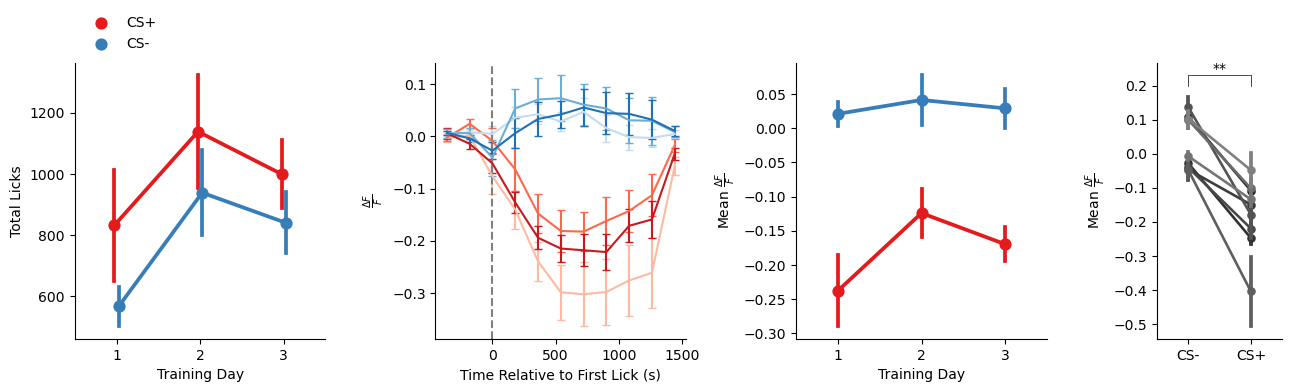

In [13]:
# create subplot
fig, ax = plt.subplots(1,4, figsize = (13,4), gridspec_kw={'width_ratios': [1, 1, 1, .5]})

# plot the total licks over the course of training
ax[0].set_prop_cycle(color = sns.color_palette('Set1'))
sns.pointplot(data = train_stats, x = 'day', y = 'total_licks', hue = 'CS', 
              errorbar = 'se', dodge = True, hue_order = ['+','-'], ax = ax[0])
ax[0].set(xlabel='Training Day', xticks = [0,1,2], xticklabels = [1,2,3], ylabel='Total Licks')
ax[0].legend(ax[0].get_legend_handles_labels()[0], ['CS+', 'CS-'], bbox_to_anchor=(0,1), loc='lower left', frameon=False)

# plot the binned data for all sessions and color code by CS
# cs + 
for i,j in zip(cs['+'], sns.color_palette('Reds', 3)):
    first_lick.bin_plot(180, cond = i, ax = ax[1], color =j ,show=False, scale=1);

# cs-
for i,j in zip(cs['-'], sns.color_palette('Blues', 3)):
    first_lick.bin_plot(180, cond = i, ax = ax[1], color =j ,show=False,scale=1);
ax[1].axvline(0,ls='--',c='grey')
ax[1].set(xlabel = 'Time Relative to First Lick (s)',
          ylabel = r'$\frac{\Delta F}{F}$')
ax[1].get_legend().remove()


# plot mean df/f over training
sns.pointplot(train_stats, x='day', y='meandf', hue='CS', 
              errorbar = 'se', ax=ax[2], hue_order = ['+','-'])

ax[2].set_ylabel(r"Mean $\frac{\Delta F}{F}$")
ax[2].set_xlabel("Training Day")
ax[2].get_legend().remove()



# plot average mean df/f for CS+ and CS- trials for each mouse
sns.pointplot(data = train_stats, x='CS', y='meandf', hue='mouse',
              errorbar='se', order=['-','+'], color='gray',
              ax=ax[3], scale=.7)
ax[3].get_legend().remove()


# plot stats
mean_stat = pd.Series(st.wilcoxon(mn_train_stats['meandf']['+'], 
                                  mn_train_stats['meandf']['-']), 
                      index=('W', 'p-value'))
plot_significance(mean_stat.loc['p-value'], ax[3], 0,1,0.2,.03)
ax[3].set(xlim = (-.5,1.5), xticks = (0,1),
          xticklabels = ['CS-', 'CS+'],
          ylabel = r'Mean $\frac{\Delta F}{F}$', xlabel = '');


# format the plot
sns.despine()
fig.tight_layout(pad = 1.)

# save the figure
fig.savefig(os.path.join(first_lick_pdfs, 'training_summary.pdf'))
fig.savefig(os.path.join(first_lick_svgs, 'training_summary.svg'))

#### stats

##### stats - training licks

F Value  Num DF  Den DF    Pr > F Significance
day     6.004404     2.0    16.0  0.011340            *
CS      6.982617     1.0     8.0  0.029600            *
day:CS  0.166289     2.0    16.0  0.848247           ns

t   p-value   df  Corrected p-value Significance
Comparison                                                             
Day 1 vs Day 2 -2.867623  0.020905  8.0           0.041373            *
Day 1 vs Day 3 -2.867623  0.020905  8.0           0.041373            *

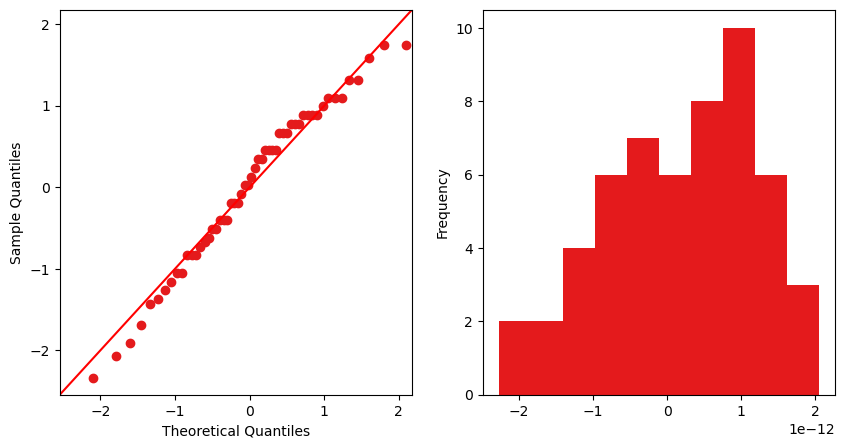

In [14]:
lick_anova = AnovaRM(train_stats, 'total_licks', 'mouse', within = ['day','CS']).fit().summary().tables[0]
lick_anova['Significance'] = lick_anova['Pr > F'].apply(check_significance)

r = smf.ols('total_licks ~ C(day,Sum)*C(CS,Sum)*C(mouse,Sum)', data = train_stats).fit().resid

_, ax = plt.subplots(1,2, figsize = (10,5))
sm.qqplot(r, fit=True, line='45', ax = ax[0])
r.plot.hist(ax=ax[1])

mn_train_licks = train_stats.groupby(['mouse','day']).total_licks.mean().unstack('day')
t = st.ttest_rel(mn_train_licks[1], mn_train_licks[2])
d1v2 = pd.Series(list(t) + [t.df], index=('t', 'p-value', 'df'))
t = st.ttest_rel(mn_train_licks[1], mn_train_licks[2])
d1v3 = pd.Series(list(t) + [t.df], index=('t', 'p-value', 'df'))
lick_stats = pd.concat({'Day 1 vs Day 2': d1v2, 'Day 1 vs Day 3': d1v3}).unstack()
lick_stats['Corrected p-value'] = multipletests(lick_stats['p-value'], method='holm-sidak')[1]
lick_stats.index.name = "Comparison"
lick_stats['Significance'] = lick_stats['Corrected p-value'].apply(check_significance)

display(lick_anova, lick_stats)

main_train_fig_stats.update({'c_train_licks_anova': lick_anova,
                             'c_train_licks_stats': lick_stats})

##### stats - full traces

In [15]:
binned = first_lick.bin_data(180, save=False)[1].T.stack()
binned.name = 'df'
binned = reindex(binned)
binned.columns.name = ''
binned = binned.reset_index()
binned = binned.rename(columns = {'bin start (s)': 'time'})

/Users/nathanielnyema/Downloads/photometry-scripts/analysis_pipeline.py:698: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  binned.groupby('cond',axis=1).sem()],


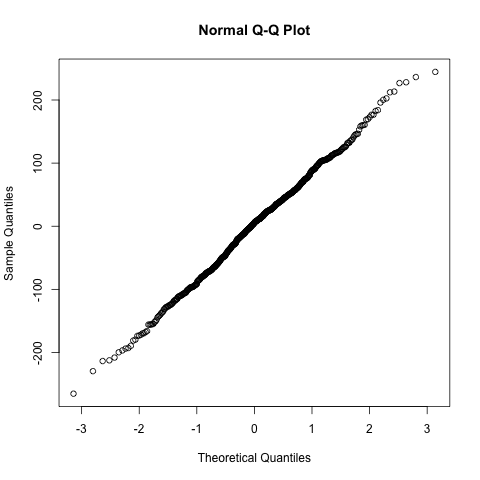

In [16]:
%%R -i binned -o anova_train_trace 
m <- lmer("rank(df) ~ factor(day)*factor(cs)*factor(time) + (1|mouse)", binned)
qqnorm(residuals(m))
anova_train_trace <- anova(m)

In [17]:
anova_train_trace['Significance'] = anova_train_trace['Pr(>F)'].apply(check_significance)

bd =   binned.groupby(['cs', 'mouse', 'time']).df.mean().unstack('cs')
pvm =  bd.groupby('time').apply(lambda x: st.wilcoxon(x['+'], x['-'])).apply(lambda x: pd.Series(x, index = ('W','p-value')))

bd = binned.groupby(['day','cs','mouse']).df.mean().unstack('cs').apply(lambda x: x['+'] - x['-'], axis=1)
d1v2_cspvm = pd.Series(st.wilcoxon(bd.loc[1],bd.loc[2]), ('W', 'p-value')).rename(np.nan).to_frame().T
d1v3_cspvm  = pd.Series(st.wilcoxon(bd.loc[1],bd.loc[3]), ('W', 'p-value')).rename(np.nan).to_frame().T

stats_train_trace = pd.concat({'Day 1 vs Day 2 Mean CS+ - Mean CS-': d1v2_cspvm , 
                               'Day 1 vs Day 3 Mean CS+ - Mean CS-': d1v3_cspvm , 
                               'CS+ vs CS-': pvm})

stats_train_trace['Corrected p-value'] = multipletests(stats_train_trace['p-value'], method='holm-sidak')[1]
stats_train_trace.index = stats_train_trace.index.set_names(["Comparison", "Time"])
stats_train_trace['Significance'] = stats_train_trace['Corrected p-value'].apply(check_significance)

display(anova_train_trace, stats_train_trace)

main_train_fig_stats.update({'d_train_trace_anova_ranks': anova_train_trace,
                             'd_train_trace_stats': stats_train_trace})

Sum Sq       Mean Sq  NumDF  DenDF  \
factor(day)                          1.510326e+05  7.551631e+04      2  520.0   
factor(cs)                           5.942603e+06  5.942603e+06      1  520.0   
factor(time)                         1.474309e+06  1.474309e+05     10  520.0   
factor(day):factor(cs)               1.757397e+05  8.786987e+04      2  520.0   
factor(day):factor(time)             1.312312e+05  6.561558e+03     20  520.0   
factor(cs):factor(time)              2.443614e+06  2.443614e+05     10  520.0   
factor(day):factor(cs):factor(time)  7.042408e+04  3.521204e+03     20  520.0   

                                        F value        Pr(>F) Significance  
factor(day)                            9.021110  1.408046e-04          ***  
factor(cs)                           709.897985  2.866585e-99         ****  
factor(time)                          17.611956  9.811293e-28         ****  
factor(day):factor(cs)                10.496854  3.395421e-05         ****  
factor(day):factor(time)               0.783838  7.343946e-01           ns  
factor(cs):factor(time)               29.191190  1.658638e-44         ****  
factor(day):factor(cs):factor(time)    0.420640  9.881041e-01           ns

W   p-value  Corrected p-value  \
Comparison                         Time                                         
Day 1 vs Day 2 Mean CS+ - Mean CS- NaN       5.0  0.039062           0.180638   
Day 1 vs Day 3 Mean CS+ - Mean CS- NaN      11.0  0.203125           0.511690   
CS+ vs CS-                         -360.0   10.0  0.164062           0.511690   
                                   -180.0   21.0  0.910156           0.910156   
                                    0.0     14.0  0.359375           0.589600   
                                    180.0    0.0  0.003906           0.049608   
                                    360.0    0.0  0.003906           0.049608   
                                    540.0    0.0  0.003906           0.049608   
                                    720.0    0.0  0.003906           0.049608   
                                    900.0    0.0  0.003906           0.049608   
                                    1080.0   0.0  0.003906           0.049608   
                                    1260.0   0.0  0.003906           0.049608   
                                    1440.0   0.0  0.003906           0.049608   

                                           Significance  
Comparison                         Time                  
Day 1 vs Day 2 Mean CS+ - Mean CS- NaN               ns  
Day 1 vs Day 3 Mean CS+ - Mean CS- NaN               ns  
CS+ vs CS-                         -360.0            ns  
                                   -180.0            ns  
                                    0.0              ns  
                                    180.0             *  
                                    360.0             *  
                                    540.0             *  
                                    720.0             *  
                                    900.0             *  
                                    1080.0            *  
                                    1260.0            *  
                                    1440.0            *

##### stats - average mean ∆F/F per day

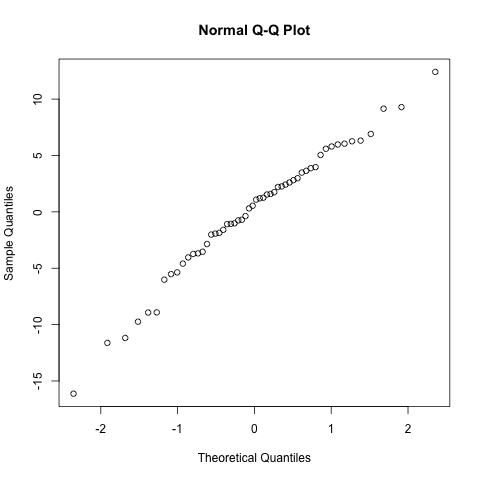

In [18]:
%%R -i train_stats -o mean_anova_ranks
m <- lmer("rank(meandf) ~ factor(day)*factor(CS) + (1|mouse)", train_stats)
qqnorm(residuals(m))
mean_anova_ranks <- anova(m)

In [19]:
mean_anova_ranks['Significance'] = mean_anova_ranks['Pr(>F)'].apply(check_significance)
df = train_stats.groupby(['day','mouse']).meandf.mean()
d1v2 = pd.Series(st.wilcoxon(df.loc[1], df.loc[2]), index = ('W', 'p-value')).to_frame().T
d1v3 = pd.Series(st.wilcoxon(df.loc[1], df.loc[3]), index = ('W', 'p-value')).to_frame().T
mean_stat_perd = pd.concat({'Day 1 vs Day 2': d1v2, 
                            'Day 1 vs Day 3': d1v3, 
                            }, names = ['Comparison']).droplevel(1)
mean_stat_perd['Corrected p-value'] = multipletests(mean_stat_perd['p-value'], method='holm-sidak')[1]
mean_stat_perd['Significance'] = mean_stat_perd['Corrected p-value'].apply(check_significance)


display(mean_anova_ranks, mean_stat_perd)


supp_train_fig_bulk_stats = {"a_mean_anova_ranks": mean_anova_ranks,
                             "a_mean_trace_stats": mean_anova_ranks}

Sum Sq      Mean Sq  NumDF      DenDF  \
factor(day)              269.777778   134.888889      2  40.000007   
factor(CS)              8238.685427  8238.685427      1  40.000007   
factor(day):factor(CS)   158.370370    79.185185      2  40.000007   

                           F value        Pr(>F) Significance  
factor(day)               3.258187  4.887456e-02            *  
factor(CS)              199.002121  4.065144e-17         ****  
factor(day):factor(CS)    1.912686  1.609487e-01           ns

W   p-value  Corrected p-value Significance
Comparison                                                   
Day 1 vs Day 2  1.0  0.007812           0.015564            *
Day 1 vs Day 3  2.0  0.011719           0.015564            *

##### stats - average mean ∆F/F comparison

In [20]:
mean_stat = mean_stat.rename("CS+ vs CS-").to_frame().T
mean_stat['Significance'] = check_significance(mean_stat['p-value'].values[0])
display(mean_stat)
main_train_fig_stats.update({"e_mean_stat": mean_stat})

W   p-value Significance
CS+ vs CS-  0.0  0.003906           **

In [21]:
with pd.ExcelWriter('stats/raw/supp_train_full_trace_stats.xlsx') as writer:  
    for k,v in supp_train_fig_bulk_stats.items():
        v.to_excel(writer, sheet_name=k)

## bout level analyses

Here we're interested in whether or not we can identify faster dynamics time-locked to the initiation of lick bouts. First we need to identify the onsets of lick bouts.

In [22]:
# load training data
training = analysis(norm_method, t_dur, norm = False,
                    ds_freq = ds_freq, ex = ex, detrend = detrend, 
                    detrend_method = detrend_method)
training.load_append_save(cohort1_data_dir/'training.npy')
training.load_append_save(cohort2_data_dir/'training.npy')
training.remove_mouse('adm480')

loading data from file...
loading data from file...


/Users/nathanielnyema/Downloads/photometry-scripts/analysis_pipeline.py:408: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.excluded_raw.append(self.raw_data.xs(pd.IndexSlice[:,mouse], drop_level=False))


recomputing...
successful


/Users/nathanielnyema/Downloads/photometry-scripts/analysis_pipeline.py:326: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.err_490=self.all_490.groupby('cond',axis=1).sem()
/Users/nathanielnyema/Downloads/photometry-scripts/analysis_pipeline.py:330: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.err_405=self.all_405.groupby('cond',axis=1).sem()


In [23]:
# compute lick bout times for training
for i,v in training.raw_data.items():
    l = training.raw_data.loc[i].events['left_licks'] 
    ili = np.append(bout_thresh + 1, l[1:] - l[:-1])
    training.raw_data.loc[i].events['left_bouts'] = l[ili > bout_thresh]

# compute lick rates during training
lr_train = get_lick_rate(training, 'left_licks', sigma = .4, win = 2)
peri_bout_lr = peri_event(training, 'left_bouts', peri_window, df = lr_train)
peri_bout_lr = reindex(peri_bout_lr) 

In [24]:
orig_training = deepcopy(training) # keep a version before detrending

# remove timestamps corresponding to datapoints that will be lost to the moving average
old_t = training.all_490.index.values
new_t = old_t[int(ds_freq * w_rad):-int(ds_freq *w_rad)]

# estimate the baseline with a moving average
bl = training.all_490.apply(lambda x: pd.Series(signal.convolve(x, kernel, mode='valid'), index = new_t), axis=0)

# update the end and start time fields in the analysis object
training.t_prestim = -new_t[0]
training.t_endrec = new_t[-1]
training.all_490 = training.all_490.loc[bl.index]

# normalize relative to the baseline
training.all_490 = (training.all_490.copy() - bl)/bl

# #z-score ∆F/Fs relative to baseline activity for each session
training.all_490 = (training.all_490 - training.all_490.loc[:0].mean(axis=0))/training.all_490.loc[:0].std(axis=0)

In [25]:
# check how many bouts we are removing due to
max_rm_bouts = training.raw_data.map(lambda x: (x.events['left_bouts']>training.t_endrec).sum()).max()
mn_rm_bouts = training.raw_data.map(lambda x: (x.events['left_bouts']>training.t_endrec).sum()).mean()
print('max removed bouts:', max_rm_bouts , '\nmean number bouts removed:', mn_rm_bouts)

max removed bouts: 1 
mean number bouts removed: 0.2777777777777778


### (supplemental) - demo of detrending method

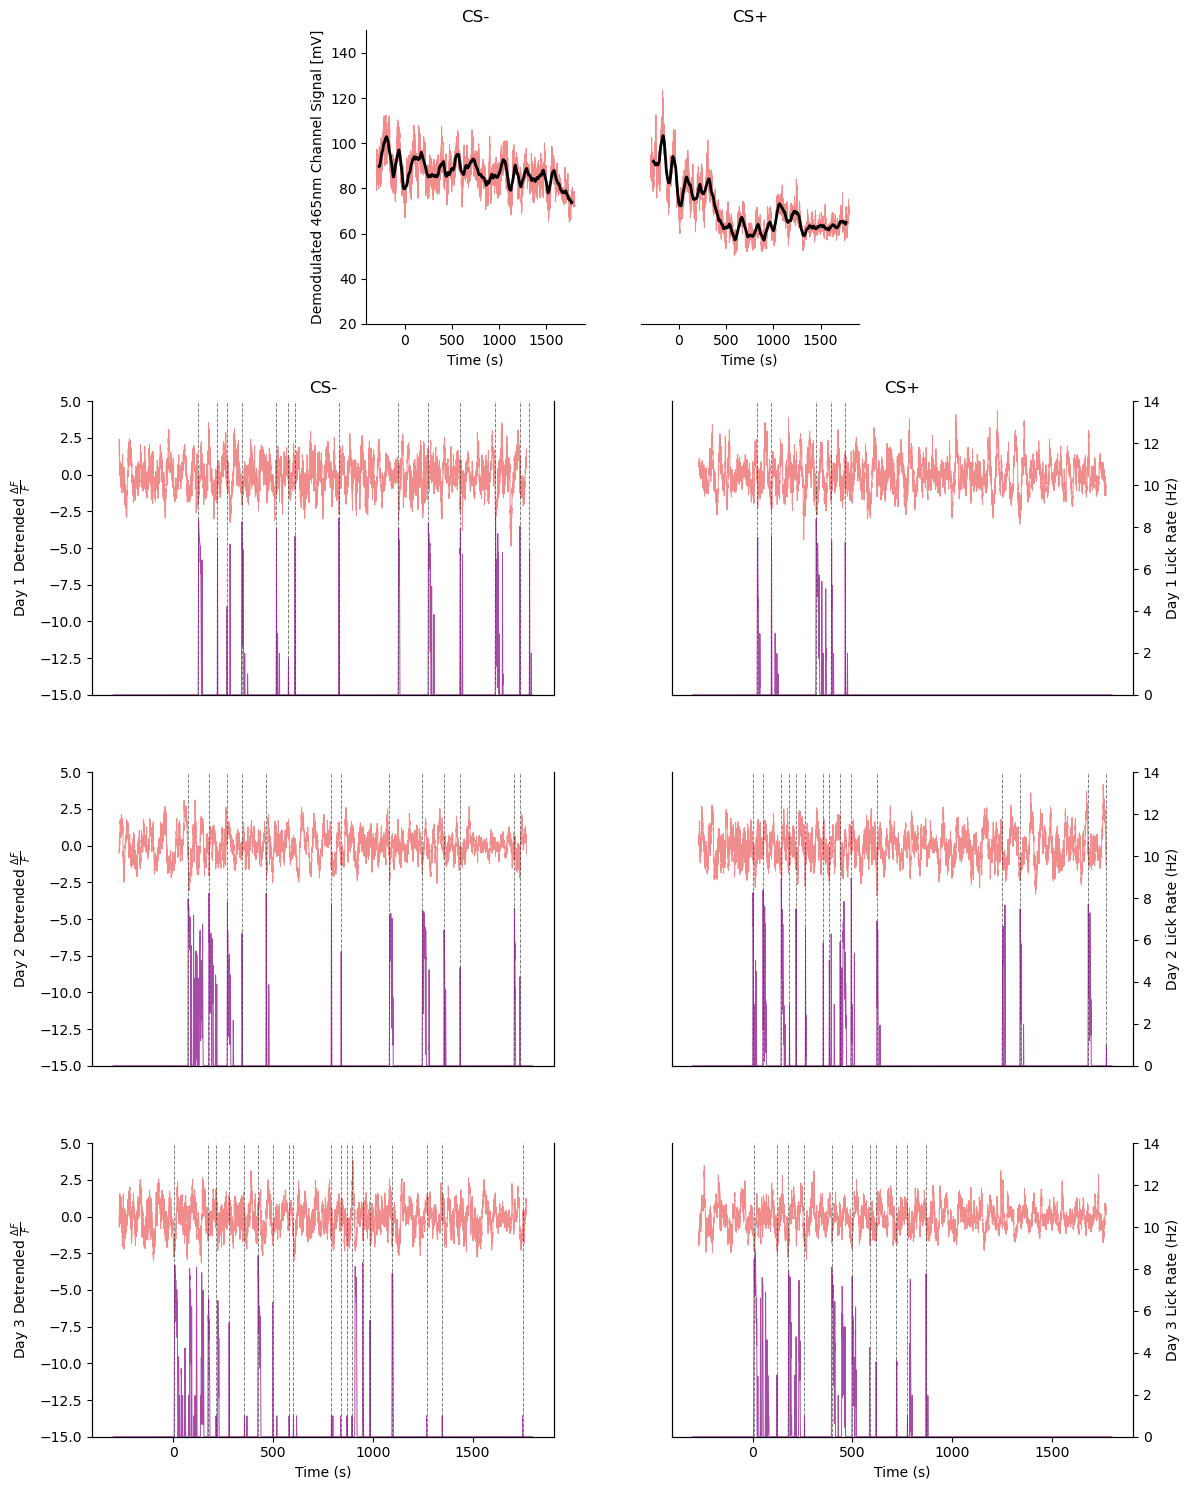

In [26]:
# create the plot
fig = plt.figure(figsize = (12,15))

# plot example model fit for a CS- session
m = 'adm485' # example mouse
ylim = (20, 150)
ax = fig.add_subplot(442)
ax.plot(orig_training.all_490['training_3_am', m], alpha = .5, lw = .7)
ax.plot( bl['training_3_am', m], c = 'k', lw = 2)
ax.set_ylabel(r'Demodulated 465nm Channel Signal [mV]')
ax.set_xlabel('Time (s)')
ax.set_title("CS-")
ax.set_ylim(ylim)
sns.despine()

# plot example model fit for CS+ session
ax = fig.add_subplot(443)
ax.plot(orig_training.all_490['training_3_pm',m], alpha = .5, lw = .7)
ax.plot(bl['training_3_pm', m], c = 'k', lw = 2)
ax.set_yticks([])
ax.set_xlabel('Time (s)')
ax.set_ylim(ylim)
ax.set_title("CS+")
sns.despine(ax = ax, left = True)
fig.tight_layout(pad = 1.)


# plot detrended CS+ data on top of lick rate
# day 1
# CS-
ylim  = (-15,5)
lylim = (0,14)
ax = fig.add_subplot(423)
ax.plot(training.all_490['training_1_am',m], alpha=.5,  lw = .7)
ax2 = ax.twinx()
ax2.plot(lr_train['training_1_am',m],  c = 'purple', alpha=.7, lw = .7)
ax.vlines(training.raw_data.loc['training_1_am',m,0].events['left_bouts'], ylim[0], ylim[1], lw=.7, color='k', alpha=.5, ls = '--')
ax.set_ylim(ylim)
ax.set_xticks([])
ax.set_title("CS-")
ax.set_ylabel(r"Day 1 Detrended $\frac{\Delta F}{F}$")
ax2.set_ylim(lylim)
ax2.set_yticks([])
sns.despine(ax = ax, top=True, right=False)
sns.despine(ax = ax2, top=True, right=False)


#CS+
ax = fig.add_subplot(424)
ax.plot(training.all_490['training_1_pm',m], alpha=.5,  lw = .7)
ax2 = ax.twinx()
ax2.plot(lr_train['training_1_pm',m], c = 'purple', alpha=.7, lw = .7)
ax.vlines(training.raw_data.loc['training_1_pm',m,0].events['left_bouts'], ylim[0], ylim[1], lw=.7, color='k', alpha=.5, ls = '--')
ax.set_ylim(ylim)
ax.set_yticks([])
ax.set_xticks([])
ax.set_title("CS+")
ax2.set_ylim(lylim)
ax2.set_ylabel("Day 1 Lick Rate (Hz)")
sns.despine(ax = ax, top=True, right=False)
sns.despine(ax = ax2, top=True, right=False)

# day 2
# CS-
ax = fig.add_subplot(425)
ax.plot(training.all_490['training_2_pm',m], alpha=.5,  lw = .7)
ax2 = ax.twinx()
ax2.plot(lr_train['training_2_pm',m],  c = 'purple', alpha=.7, lw = .7)
ax.vlines(training.raw_data.loc['training_2_pm',m,0].events['left_bouts'], ylim[0], ylim[1], lw=.7, color='k', alpha=.5, ls = '--')
ax.set_ylim(ylim)
ax.set_xticks([])
ax.set_ylabel(r"Day 2 Detrended $\frac{\Delta F}{F}$")
ax2.set_ylim(lylim)
ax2.set_yticks([])
sns.despine(ax = ax, top=True, right=False)
sns.despine(ax = ax2, top=True, right=False)


#CS+
ax = fig.add_subplot(426)
ax.plot(training.all_490['training_2_am',m], alpha=.5,  lw = .7)
ax2 = ax.twinx()
ax2.plot(lr_train['training_2_am',m], c = 'purple', alpha=.7, lw = .7)
ax.vlines(training.raw_data.loc['training_2_am',m,0].events['left_bouts'], ylim[0], ylim[1], lw=.7, color='k', alpha=.5, ls = '--')
ax.set_ylim(ylim)
ax.set_yticks([])
ax.set_xticks([])
ax2.set_ylim(lylim)
ax2.set_ylabel("Day 2 Lick Rate (Hz)")
sns.despine(ax = ax, top=True, right=False)
sns.despine(ax = ax2, top=True, right=False)

# day 3
# CS-
ax = fig.add_subplot(427)
ax.plot(training.all_490['training_3_am',m], alpha=.5,  lw = .7)
ax2 = ax.twinx()
ax2.plot(lr_train['training_3_am',m], c = 'purple', alpha=.7, lw = .7)
ax.vlines(training.raw_data.loc['training_3_am',m,0].events['left_bouts'], ylim[0], ylim[1], lw=.7, color='k', alpha=.5, ls = '--')
ax.set_ylim(ylim)
ax.set_xlabel("Time (s)")
ax.set_ylabel(r"Day 3 Detrended $\frac{\Delta F}{F}$")
ax2.set_ylim(lylim)
ax2.set_yticks([])
sns.despine(ax = ax, top=True, right=False)
sns.despine(ax = ax2, top=True, right=False)


#CS+
ax = fig.add_subplot(428)
ax.plot(training.all_490['training_3_pm',m], alpha=.5,  lw = .7)
ax2 = ax.twinx()
ax2.plot(lr_train['training_3_pm',m],  c = 'purple', alpha=.7, lw = .7)
ax.vlines(training.raw_data.loc['training_3_pm',m,0].events['left_bouts'], ylim[0], ylim[1], lw=.7, color='k', alpha=.5, ls = '--')
ax.set_ylim(ylim)
ax.set_yticks([])
ax.set_xlabel("Time (s)")
ax2.set_ylim(lylim)
ax2.set_ylabel("Day 3 Lick Rate (Hz)")
sns.despine(ax = ax, top=True, right=False)
sns.despine(ax = ax2, top=True, right=False)


# format plot
fig.tight_layout(h_pad = 1, w_pad = .001)

# save the figure
fig.savefig(os.path.join('figures', 'methods', 'pdfs', 'supplement_detrending.pdf'))
fig.savefig(os.path.join('figures', 'methods', 'svgs', 'supplement_detrending.svg'))

### extracting peri-lick bout activity within different time ranges of the data

In [27]:
# get peri-bout activity for all bouts
bn= training.raw_data.apply(lambda x: get_bn(x, 'left_licks', 'left_bouts'))
for i in training.raw_data.index:
    # only include bouts with more than one lick
    training.raw_data[i].events['valid_bouts'] = training.raw_data[i].events['left_bouts'][bn.loc[i].dropna().values>1]
bn = reindex(bn.droplevel('trial').T)
bn.columns.name = 'event'
peri_bout = peri_event(training, 'valid_bouts', peri_window, norm = peri_bout_norm_train)
peri_bout = reindex(peri_bout)
mn_peri_bout = peri_bout.groupby(['day','cs','mouse']).mean()

### randomize

In [28]:
# simmulate random lick bouts and get corresponding peri bout activity
np.random.seed(32)
ctl = []

with tqdm(total = niters_rand) as pbar:
    def randomize_bouts(pid):
        global ctl_mn
        global training
        
        end_lim = training.all_490.index[-1]-peri_window-1
        for i,v in training.raw_data.items():
            # create an array of times to sample
            ts = np.arange(0, end_lim + 1/100, step = 1/100)
            n = v.events['valid_bouts'].size # get the number of bouts to sample
            rand_evs = np.empty((n,))

            for j in range(n):
                #choose a bout onset time from available times
                rand_evs[j] = np.random.choice(ts)
                # remove the selected time from avavilable times array
                # as well as any times within the bout threshold
                ts = ts[np.abs(ts - rand_evs[j]) > bout_thresh]  
            
            #save randomized bouts
            training.raw_data.loc[i].events[f'rand_bouts_{pid}'] = np.sort(rand_evs) 
            
        # get peri-bout data for random bouts and compute the mean response
        _d = peri_event(training, f'rand_bouts_{pid}', peri_window,norm = peri_bout_norm_test)
        _d = _d.groupby(['cond','mouse'], axis=1).mean()
        ctl.append(_d)

    with ThreadPoolExecutor(max_workers=2) as pool:
        futures = [pool.submit(randomize_bouts, i) for i in range(niters_rand)]
        for future in as_completed(futures):
            pbar.update(1)

ctl = reindex(pd.concat(dict(zip(range(len(ctl)), ctl)), 
                        axis=1, names = ['event']))
ctl_mn = ctl.groupby(['day','cs','mouse']).mean()

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:24<00:00,  4.04it/s]


### plot average peri-bout activity for each session

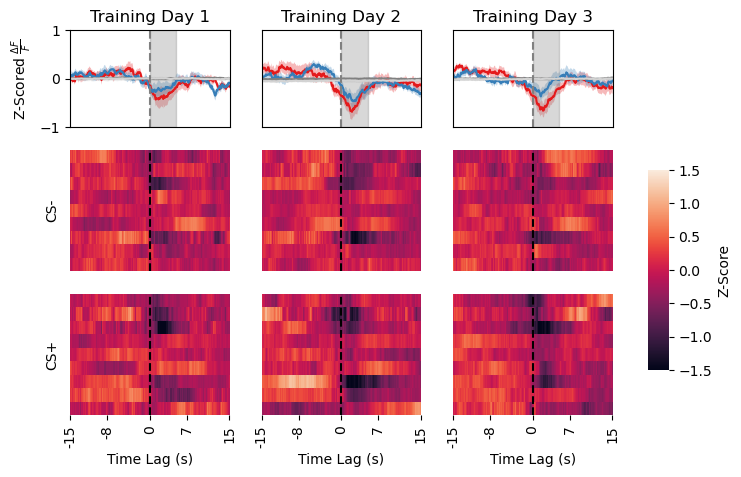

In [29]:
fig, ax = plot_peri(mn_peri_bout, ctl_mn, 'Training', save = False, vmin = -1.5, vmax=1.5);
for i in range(3):
    ax[0,i].fill_between([0,5],-1, 1, color='gray', alpha=.3)
fig.savefig(os.path.join(peri_stim_pdfs_train , 'training_all.pdf'), bbox_inches = 'tight')
fig.savefig(os.path.join(peri_stim_svgs_train , 'training_all.svg'), bbox_inches = 'tight')

#### individual mice

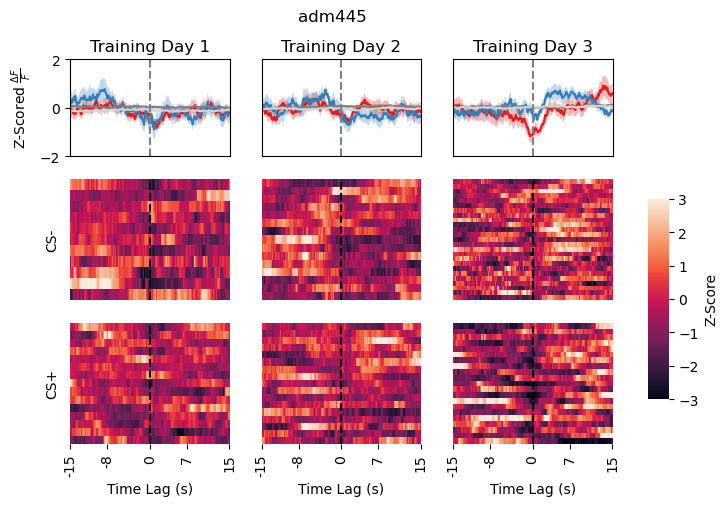

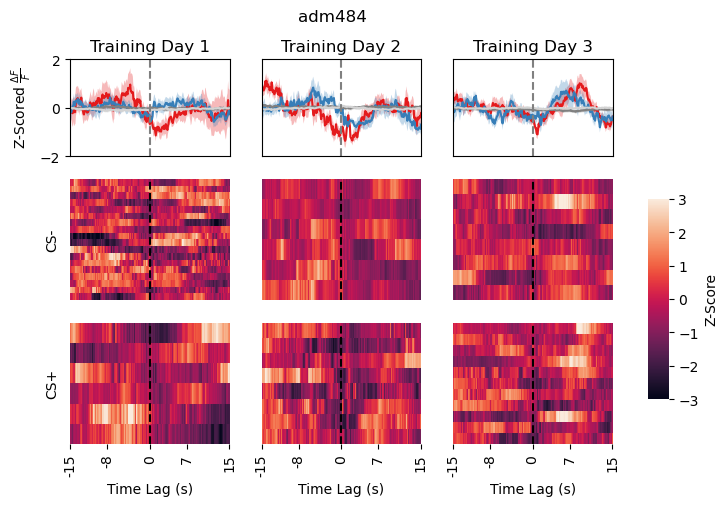

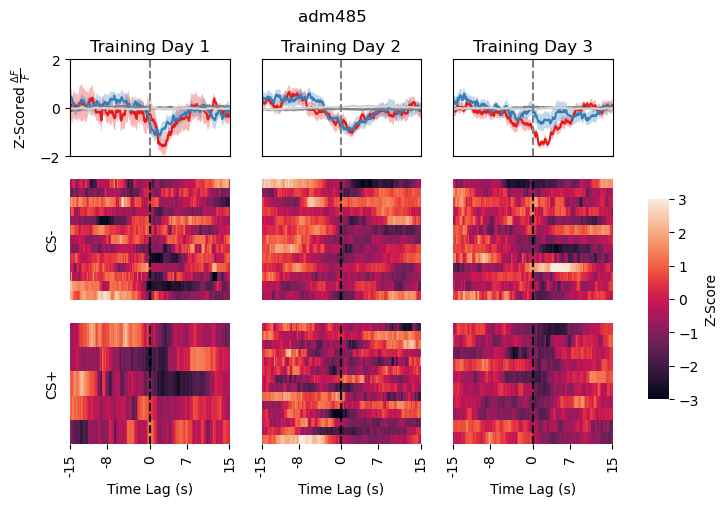

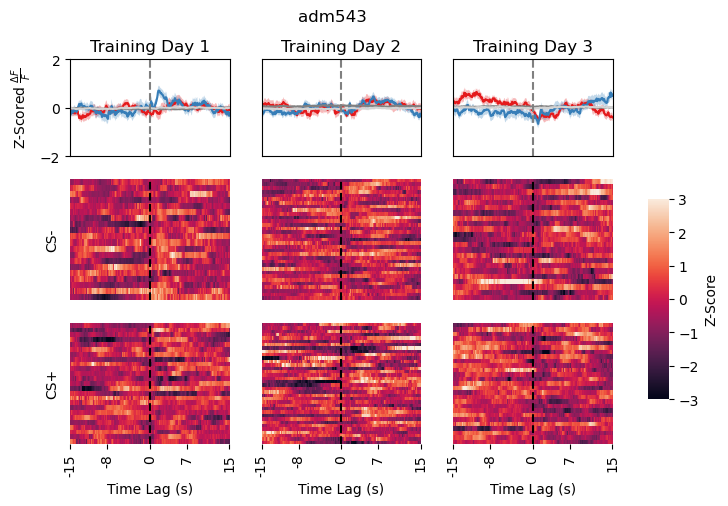

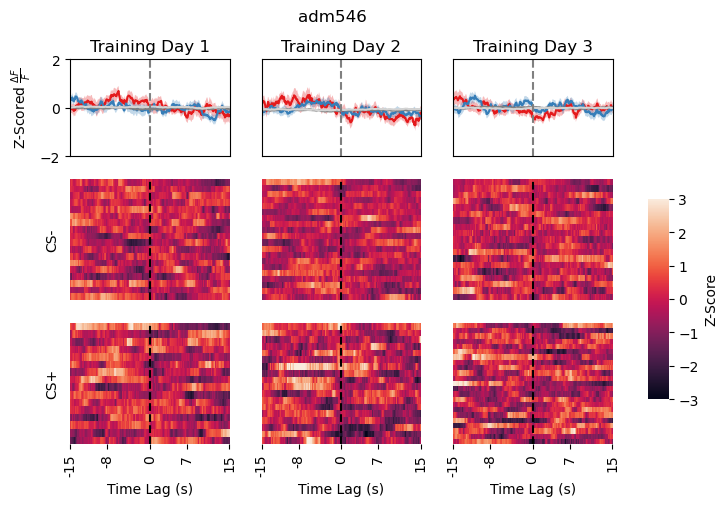

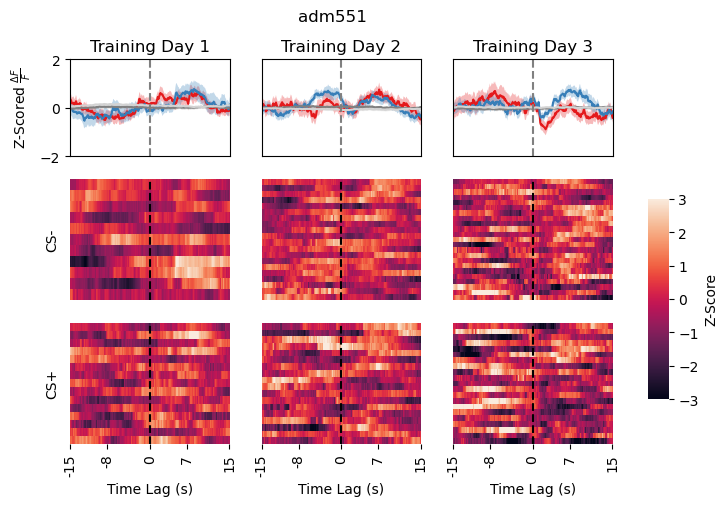

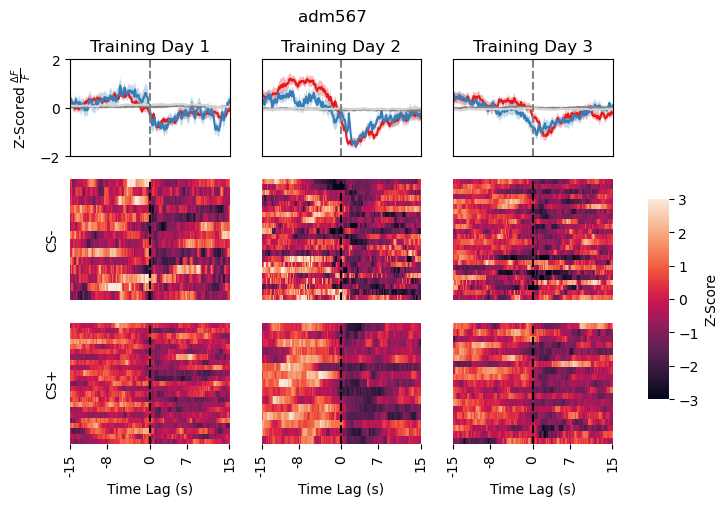

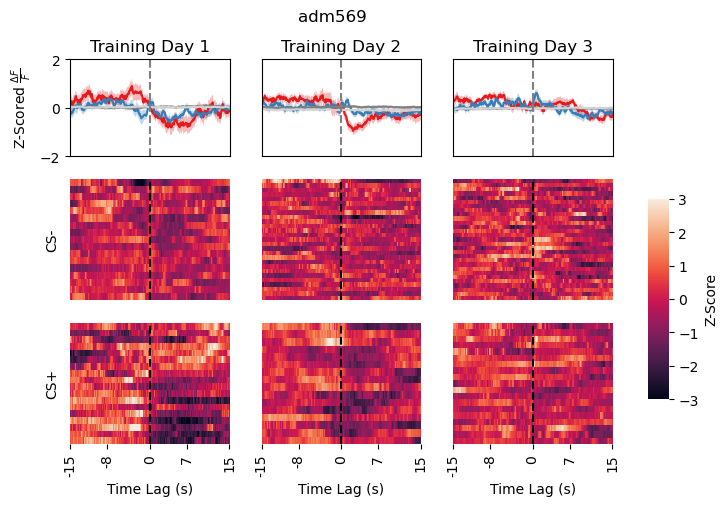

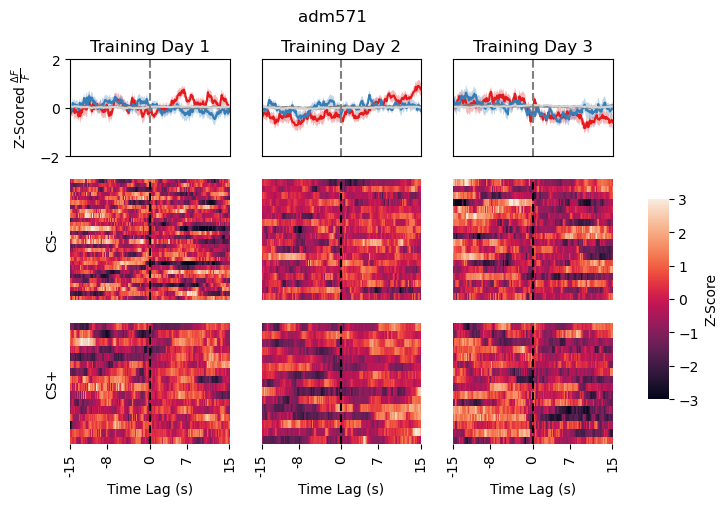

In [30]:
for i in mn_peri_bout.index.get_level_values('mouse').unique():
    fig, _ = plot_peri(peri_bout.swaplevel('day','mouse').loc[i].swaplevel('day','cs'), 
                          ctl = ctl.swaplevel('day','mouse').loc[i].swaplevel('day','cs'),
                          save=False, vmin = -3, vmax=3, ylim = (-2,2));
    fig.suptitle(i)
    os.makedirs(os.path.join(peri_stim_pdfs_train , i), exist_ok=True)  
    os.makedirs(os.path.join(peri_stim_svgs_train , i), exist_ok=True)   

    fig.savefig(os.path.join(peri_stim_pdfs_train , i,  'training_all.pdf'), bbox_inches = 'tight')
    fig.savefig(os.path.join(peri_stim_svgs_train , i, 'training_all.svg'), bbox_inches = 'tight')

#### stats

##### stats - compare lick bouts to be sure the corresponding bout numbers for all bout triggered averages are comparable

In [31]:
nb_train =  peri_bout.groupby(['day','cs','mouse']).size().rename('nb').reset_index()
nb_train = (nb_train.groupby(['day','cs']).nb.mean().round(2).astype(str) + ' ± '\
            + nb_train.groupby(['day','cs']).nb.sem().round(2).astype(str))
display(nb_train.unstack('cs'))
main_train_fig_stats.update({'g_n_train_bouts': nb_train})

cs              +             -
day                            
1    15.44 ± 2.22  16.67 ± 1.78
2    17.44 ± 2.53  19.33 ± 2.61
3    18.56 ± 1.83  20.22 ± 2.17

##### stats - compare bout triggered averages

In [32]:
peri_binned = bin_peri_bout(peri_bout,1).stack().rename('df').reset_index()


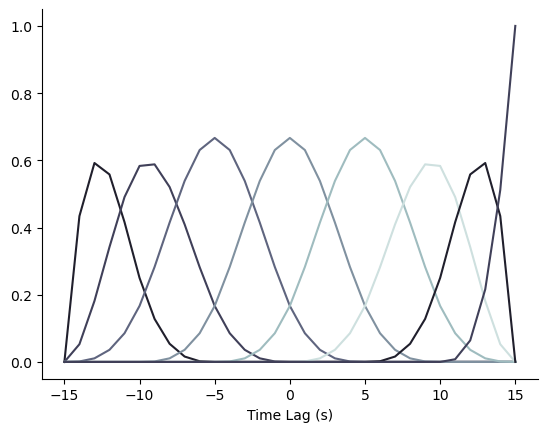

In [33]:
from patsy import dmatrix
# quick illustrationo of the regression splines
x=np.sort(peri_binned.bins.unique())
splines = dmatrix("bs(x, df=8, degree=3, include_intercept=False) -1", {"x":x}, return_type="dataframe").values
_, ax = plt.subplots(1,1)
ax.set_prop_cycle(color=sns.color_palette("bone",6))
ax.plot(x, splines)
ax.set_xlabel("Time Lag (s)")
sns.despine()
splines = splines/splines.sum(axis=0)

R[write to console]: boundary (singular) fit: see help('isSingular')



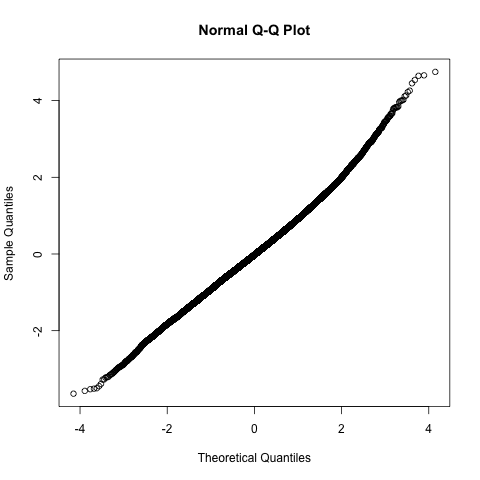

In [34]:
%%R -i peri_binned -o all_anova -o all_model
m <- lmer('df ~ 1 +  factor(day)*bs(bins, df=8, degree=3)*factor(cs)+ (1 + bs(bins, df=8, degree=3)|mouse)', data = peri_binned)
all_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
all_anova <- anova(m)

In [35]:
all_anova['Significance'] = all_anova['Pr(>F)'].apply(check_significance)
all_model['Significance'] = all_model['Pr(>|t|)'].apply(check_significance)

display(all_anova, all_model)
main_train_fig_stats.update({'g_peri_bout_anovas': all_anova,
                             'g_peri_bout_model':   all_model
                            })

Sum Sq   Mean Sq  \
factor(day)                                          1.907669  0.953834   
bs(bins, df = 8, degree = 3)                        45.785646  5.723206   
factor(cs)                                           1.361176  1.361176   
factor(day):bs(bins, df = 8, degree = 3)            43.516194  2.719762   
factor(day):factor(cs)                               4.136374  2.068187   
bs(bins, df = 8, degree = 3):factor(cs)             49.699340  6.212418   
factor(day):bs(bins, df = 8, degree = 3):factor...  48.637208  3.039826   

                                                    NumDF         DenDF  \
factor(day)                                             2  29788.255355   
bs(bins, df = 8, degree = 3)                            8     11.686490   
factor(cs)                                              1  29848.873183   
factor(day):bs(bins, df = 8, degree = 3)               16  28984.915236   
factor(day):factor(cs)                                  2  29717.785495   
bs(bins, df = 8, degree = 3):factor(cs)                 8  29347.558376   
factor(day):bs(bins, df = 8, degree = 3):factor...     16  28586.194536   

                                                     F value        Pr(>F)  \
factor(day)                                         1.054919  3.482337e-01   
bs(bins, df = 8, degree = 3)                        6.329734  2.654875e-03   
factor(cs)                                          1.505429  2.198476e-01   
factor(day):bs(bins, df = 8, degree = 3)            3.007994  4.581879e-05   
factor(day):factor(cs)                              2.287367  1.015513e-01   
bs(bins, df = 8, degree = 3):factor(cs)             6.870791  4.574749e-09   
factor(day):bs(bins, df = 8, degree = 3):factor...  3.361977  5.687327e-06   

                                                   Significance  
factor(day)                                                  ns  
bs(bins, df = 8, degree = 3)                                 **  
factor(cs)                                                   ns  
factor(day):bs(bins, df = 8, degree = 3)                   ****  
factor(day):factor(cs)                                       ns  
bs(bins, df = 8, degree = 3):factor(cs)                    ****  
factor(day):bs(bins, df = 8, degree = 3):factor...         ****

Estimate  Std. Error  \
(Intercept)                                         0.072562    0.082011   
factor(day)2                                       -0.036819    0.099641   
factor(day)3                                       -0.047500    0.098628   
bs(bins, df = 8, degree = 3)1                       0.032418    0.151688   
bs(bins, df = 8, degree = 3)2                      -0.028253    0.124076   
bs(bins, df = 8, degree = 3)3                       0.166524    0.122979   
bs(bins, df = 8, degree = 3)4                      -0.382525    0.188794   
bs(bins, df = 8, degree = 3)5                      -0.115036    0.194068   
bs(bins, df = 8, degree = 3)6                      -0.028685    0.153452   
bs(bins, df = 8, degree = 3)7                      -0.447908    0.173991   
bs(bins, df = 8, degree = 3)8                      -0.145949    0.112825   
factor(cs)+                                        -0.098584    0.105286   
factor(day)2:bs(bins, df = 8, degree = 3)1          0.085887    0.203614   
factor(day)3:bs(bins, df = 8, degree = 3)1          0.185742    0.201554   
factor(day)2:bs(bins, df = 8, degree = 3)2         -0.336346    0.160559   
factor(day)3:bs(bins, df = 8, degree = 3)2         -0.127502    0.158931   
factor(day)2:bs(bins, df = 8, degree = 3)3          0.376447    0.162333   
factor(day)3:bs(bins, df = 8, degree = 3)3         -0.056760    0.160686   
factor(day)2:bs(bins, df = 8, degree = 3)4         -0.162163    0.146084   
factor(day)3:bs(bins, df = 8, degree = 3)4         -0.045247    0.144640   
factor(day)2:bs(bins, df = 8, degree = 3)5         -0.016476    0.157160   
factor(day)3:bs(bins, df = 8, degree = 3)5          0.209948    0.155583   
factor(day)2:bs(bins, df = 8, degree = 3)6          0.013892    0.175536   
factor(day)3:bs(bins, df = 8, degree = 3)6          0.037758    0.173787   
factor(day)2:bs(bins, df = 8, degree = 3)7          0.125227    0.177305   
factor(day)3:bs(bins, df = 8, degree = 3)7          0.259345    0.175558   
factor(day)2:bs(bins, df = 8, degree = 3)8         -0.172260    0.140808   
factor(day)3:bs(bins, df = 8, degree = 3)8          0.099956    0.139387   
factor(day)2:factor(cs)+                            0.207945    0.144119   
factor(day)3:factor(cs)+                            0.300111    0.142349   
bs(bins, df = 8, degree = 3)1:factor(cs)+           0.137615    0.215145   
bs(bins, df = 8, degree = 3)2:factor(cs)+          -0.066311    0.169653   
bs(bins, df = 8, degree = 3)3:factor(cs)+           0.295064    0.171529   
bs(bins, df = 8, degree = 3)4:factor(cs)+          -0.018049    0.154339   
bs(bins, df = 8, degree = 3)5:factor(cs)+           0.016749    0.166054   
bs(bins, df = 8, degree = 3)6:factor(cs)+           0.188167    0.185467   
bs(bins, df = 8, degree = 3)7:factor(cs)+           0.250066    0.187323   
bs(bins, df = 8, degree = 3)8:factor(cs)+           0.020691    0.148781   
factor(day)2:bs(bins, df = 8, degree = 3)1:fact... -0.130412    0.294472   
factor(day)3:bs(bins, df = 8, degree = 3)1:fact... -0.271087    0.290855   
factor(day)2:bs(bins, df = 8, degree = 3)2:fact...  0.244911    0.232214   
factor(day)3:bs(bins, df = 8, degree = 3)2:fact...  0.002005    0.229362   
factor(day)2:bs(bins, df = 8, degree = 3)3:fact... -0.569400    0.234786   
factor(day)3:bs(bins, df = 8, degree = 3)3:fact... -0.255632    0.231902   
factor(day)2:bs(bins, df = 8, degree = 3)4:fact... -0.275720    0.211130   
factor(day)3:bs(bins, df = 8, degree = 3)4:fact... -0.513936    0.208534   
factor(day)2:bs(bins, df = 8, degree = 3)5:fact... -0.108723    0.227235   
factor(day)3:bs(bins, df = 8, degree = 3)5:fact... -0.475214    0.224443   
factor(day)2:bs(bins, df = 8, degree = 3)6:fact... -0.326602    0.253773   
factor(day)3:bs(bins, df = 8, degree = 3)6:fact... -0.348411    0.250654   
factor(day)2:bs(bins, df = 8, degree = 3)7:fact... -0.236745    0.256236   
factor(day)3:bs(bins, df = 8, degree = 3)7:fact... -0.571038    0.253085   
factor(day)2:bs(bins, df

### further quantification

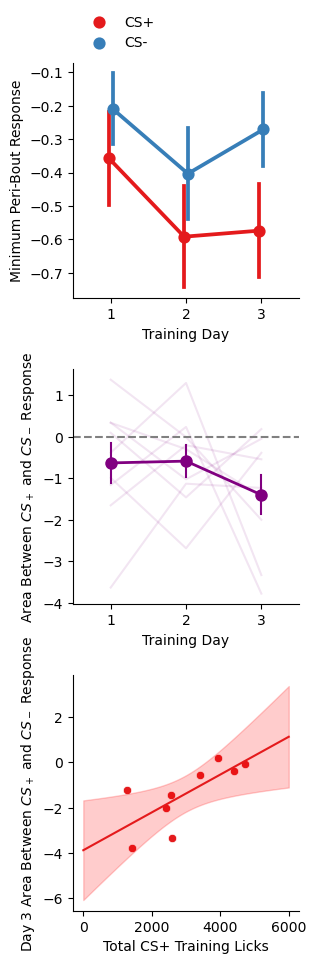

In [84]:
fig, ax = plt.subplots(3,1, figsize=(3.5,10))

# get min responses from 0 to 5s and plot
mn_loc =  mn_peri_bout.groupby(['day','cs']).mean().T.loc[0:5].idxmin(axis=0)
mn_rp = {}
for i,v in mn_loc.items():
    tmp = mn_peri_bout.loc[i].T
    tmp.index = tmp.index.astype(float)
    mn_rp.update({i:tmp.loc[v-1:v+1].mean(axis=0)})
mn_rp = pd.DataFrame(mn_rp).T
mn_rp.index = mn_rp.index.set_names(['day', 'cs'])
mn_rp = mn_rp.stack().rename('df')

g = sns.pointplot(mn_rp.reset_index(), x='day', y='df',hue='cs',
                  errorbar='se',dodge=True, ax=ax[0])
g.legend(g.get_legend_handles_labels()[0], ['CS+', 'CS-'], 
         loc = 'lower left', bbox_to_anchor = (0,1), frameon = False)
g.set_xlabel("Training Day")
g.set_ylabel("Minimum Peri-Bout Response")

abc = mn_peri_bout.swaplevel('day','cs').loc['+'].T.loc[0:5] - mn_peri_bout.swaplevel('day','cs').loc['-'].T.loc[0:5]
abc = abc.apply(lambda x: np.trapz(x.values, x=x.index), axis=0)#/mn_peri_bout.swaplevel('day','cs').loc['-'].std(axis=1)
abc = abc.rename('df').reset_index() # mn_peri_bout.swaplevel('day','cs').loc['-'].std(axis=1)
sns.lineplot(abc, x='day',y='df', errorbar='se', marker='o', markeredgewidth=0, 
             color = 'purple', err_style='bars', markersize=9, linewidth=2,
             ax=ax[1])
g = sns.lineplot(abc, x='day',y='df', errorbar='se', 
                 palette=['purple']*abc.mouse.unique().size,
                 hue='mouse',
                 ax=ax[1], alpha=0.1)
g.get_legend().remove()
ax[1].axhline(0, c = 'gray', ls = '--')
ax[1].set_ylabel("Area Between $CS_+$ and $CS_-$ Response")
ax[1].set_xlabel("Training Day")
ax[1].set_xlim(0.5,3.5)
ax[1].set_xticks(np.arange(1,4))



diff_d3 = abc.set_index(['day','mouse']).df.loc[3]
train_licks = reindex(training.raw_data.apply(lambda x: x.events['left_licks'].size).droplevel('trial'))[0]
train_licks = train_licks.groupby(['mouse','cs']).sum().loc[:, '+'].loc[diff_d3.index]
df = pd.concat({'licks':train_licks, 'diff': diff_d3}, axis=1)
d3vlicks = smf.ols('diff ~ licks', df).fit()
x = np.linspace(0,6000, 100)

pred = d3vlicks.get_prediction({'licks': x})
sns.scatterplot(data=df, x='licks', y='diff', ax = ax[2])
ax[2].plot(x, pred.predicted_mean)
ax[2].fill_between(x, pred.conf_int()[:,0], pred.conf_int()[:,1], color = 'r', alpha = 0.2)
ax[2].set(xlabel = 'Total CS+ Training Licks', ylabel = r"Day 3 Area Between $CS_+$ and $CS_-$ Response")

# format figure
sns.despine()
fig.tight_layout(pad = 2.)

# # save figure
fig.savefig(os.path.join(peri_stim_pdfs_train ,'additional_quantification.pdf'))
fig.savefig(os.path.join(peri_stim_svgs_train ,'additional_quantification.svg'))


#### stats

##### stats - minimum response

F Value  Num DF  Den DF    Pr > F Significance
cs      20.077296     1.0     8.0  0.002054           **
day      2.419303     2.0    16.0  0.120784           ns
cs:day   0.717099     2.0    16.0  0.503204           ns

t   p-value   df  Corrected p-value Significance
day                                                         
1   -1.500421  0.171897  8.0           0.171897           ns
2   -2.490868  0.037472  8.0           0.073539           ns
3   -3.129889  0.014018  8.0           0.041466            *

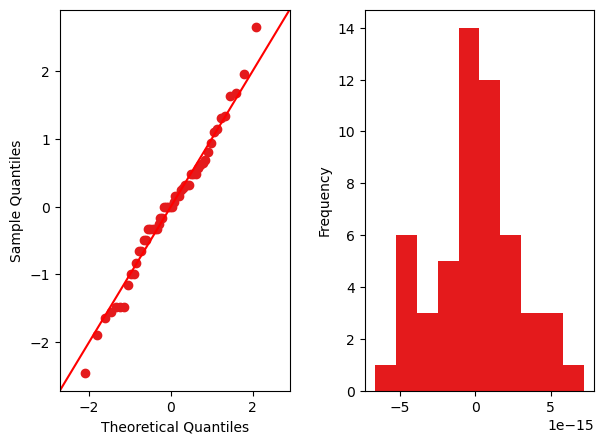

In [37]:
# fit the anova
mn_rp_anova = AnovaRM(mn_rp.reset_index(), 'df', 'mouse', 
                      within=['cs','day']).fit().summary().tables[0]
mn_rp_anova['Significance'] = mn_rp_anova['Pr > F'].apply(check_significance)

# validate normal residuals
resid = smf.ols('day~C(cs,Sum)*C(day,Sum)*C(mouse,Sum)', 
                mn_rp.reset_index()).fit().resid

fig, ax = plt.subplots(1,2)
sm.qqplot(resid, fit=True, line='45', ax = ax[0]);
resid.plot.hist(ax=ax[1])
fig.tight_layout(pad = 2.)

mn_rp_stats = mn_rp.unstack('cs').groupby('day').apply(lambda x: st.ttest_rel(x['+'], x['-'])).apply(lambda x: pd.Series(list(x) + [x.df], index = ('t', 'p-value', 'df')))
mn_rp_stats['Corrected p-value'] = multipletests(mn_rp_stats['p-value'], method='holm-sidak')[1]
mn_rp_stats['Significance'] = mn_rp_stats['Corrected p-value'].apply(check_significance)

display(mn_rp_anova, mn_rp_stats)
main_train_fig_stats.update({'h_min_resp_anova': mn_rp_anova,
                             'h_min_resp_stats': mn_rp_stats})

##### stats - area between curves correlation

In [38]:
# fit the anova

abc_friedman = st.friedmanchisquare(abc.set_index(['day','mouse']).loc[1].df, 
                                    abc.set_index(['day','mouse']).loc[2].df,
                                    abc.set_index(['day','mouse']).loc[3].df)

abc_friedman = pd.Series(abc_friedman, index=('statistic', 'p-value')).rename('ABC Friedman Test').to_frame().T
abc_friedman['Significance'] = abc_friedman['p-value'].apply(check_significance)


abc_stats = (abc.set_index(['day','mouse'])
                .groupby('day').df
                .apply(lambda x: st.wilcoxon(x))
                .apply(lambda x: pd.Series(x, index=('W', 'p-value')))
            )
abc_stats['Corrected p-value'] = multipletests(abc_stats['p-value'], method='holm-sidak')[1]
abc_stats['Significance'] = abc_stats['Corrected p-value'].apply(check_significance)

display(abc_friedman, abc_stats)
main_train_fig_stats.update({'i_ABC_friedman': abc_friedman,
                             'i_ABC_stats': abc_stats})

statistic   p-value Significance
ABC Friedman Test   0.666667  0.716531           ns

W   p-value  Corrected p-value Significance
day                                                
1    13.0  0.300781           0.301208           ns
2    10.0  0.164062           0.301208           ns
3     2.0  0.011719           0.034746            *

##### stats - area between curves correlation

In [39]:
d3vlicks_coef = pd.DataFrame(d3vlicks.summary().tables[1])
d3vlicks_coef.columns = d3vlicks_coef.iloc[0].astype(str)
d3vlicks_coef = d3vlicks_coef.set_index('').iloc[1:]
d3vlicks_r = pd.Series({'R2': d3vlicks.rsquared}).rename("Day 3 ABC vs Cummulative Training Licks Correlation").to_frame().T

display(d3vlicks_coef, d3vlicks_r)

main_train_fig_stats.update({'j_d3_ABC_lick_corr_coef': d3vlicks_coef,
                             'j_d3_ABC_lick_corr_r2': d3vlicks_r})

/Users/nathanielnyema/opt/anaconda3/envs/fnc/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


0                coef    std err          t   P>|t|     [0.025     0.975]
                                                                         
Intercept     -3.8773      0.930     -4.171   0.004     -6.076     -1.679
licks          0.0008      0.000      2.864   0.024      0.000      0.002

R2
Day 3 ABC vs Cummulative Training Licks Correla...  0.539516

In [40]:
with pd.ExcelWriter('stats/raw/train_stats.xlsx') as writer:  
    for k,v in main_train_fig_stats.items():
        v.to_excel(writer, sheet_name=k)

### (supplemental) - within session analysis

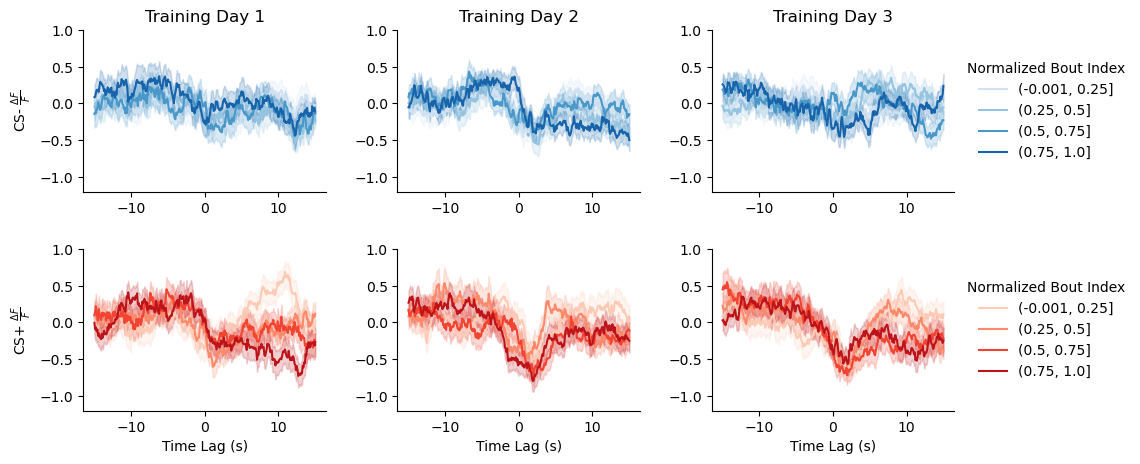

In [41]:
fig, ax = plt.subplots(2,3, figsize=(10,5))

df = peri_bout.stack().rename('df').reset_index()
df['bout_fraction'] = df.groupby(['day','cs','mouse'], group_keys=False).event.apply(lambda x: x/(x.max()))
df['bout_frac_bin'] = pd.cut(df.bout_fraction, np.arange(0,1.001, 0.25), include_lowest=True)

for i in range(3):
    sns.lineplot(df.loc[(df.day==i+1) & (df.cs=='-')], x='time', y='df', hue='bout_frac_bin',
                 errorbar='se',palette='Blues', ax=ax[0,i], legend=False if i<2 else True)
    sns.lineplot(df.loc[(df.day==i+1) & (df.cs=='+')], x='time', y='df', hue='bout_frac_bin',
                 errorbar='se',palette='Reds', markeredgewidth=0, ax = ax[1,i], legend=False if i<2 else True)
    ax[0,i].set_ylim(-1.2,1)
    ax[1,i].set_ylim(-1.2,1)
    ax[0,i].set_title(f"Training Day {i+1}")
    ax[0,i].set_ylabel("")
    ax[1,i].set_ylabel("")
    ax[0,i].set_xlabel("")
    ax[1,i].set_xlabel("Time Lag (s)")

ax[0,0].set_ylabel(r"CS- $\frac{\Delta F}{F}$")
ax[1,0].set_ylabel(r"CS+ $\frac{\Delta F}{F}$")
sns.despine()
fig.tight_layout(pad=2)


ax[0,-1].legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False, title ="Normalized Bout Index")
ax[1,-1].legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False, title ="Normalized Bout Index")

fig.savefig(os.path.join(peri_stim_pdfs_train ,'supp_within_session.pdf'))
fig.savefig(os.path.join(peri_stim_svgs_train ,'supp_within_session.svg'))

#### stats

##### stats - day 1

In [42]:
peri_binned['bout_fraction'] = peri_binned.groupby(['day','cs','mouse'], group_keys=False).event.apply(lambda x: x/x.max())
day1_binned = peri_binned.loc[peri_binned.day==1]

R[write to console]: boundary (singular) fit: see help('isSingular')



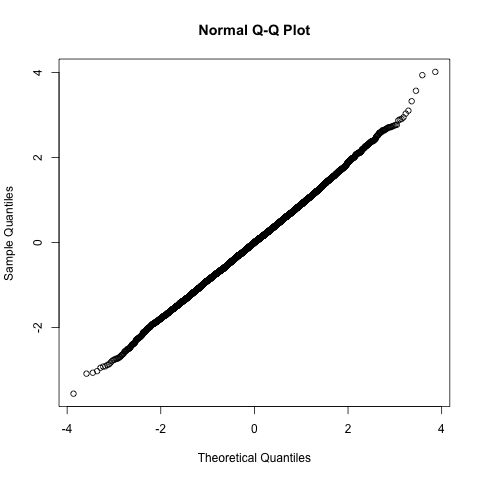

In [43]:
%%R -i day1_binned -o day1_anova -o day1_model
m <- lmer('df ~ 1+ bout_fraction*factor(cs)*bs(bins, df=8, degree=3) + (1 + bs(bins, df=8, degree=3)|mouse)', data=day1_binned)
day1_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
day1_anova <- anova(m)

In [44]:
day1_anova['Significance'] = day1_anova['Pr(>F)'].apply(check_significance)
day1_model['Significance'] = day1_model['Pr(>|t|)'].apply(check_significance)

display(day1_anova, day1_model)


supp_train_fig_peri_stats = {'day1_peri_bout_anovas': day1_anova,
                             'day1_peri_bout_stat':   day1_model}

Sum Sq    Mean Sq  \
bout_fraction                                        0.043655   0.043655   
factor(cs)                                           0.001256   0.001256   
bs(bins, df = 8, degree = 3)                        31.287762   3.910970   
bout_fraction:factor(cs)                             0.246865   0.246865   
bout_fraction:bs(bins, df = 8, degree = 3)          92.088416  11.511052   
factor(cs):bs(bins, df = 8, degree = 3)             28.871586   3.608948   
bout_fraction:factor(cs):bs(bins, df = 8, degre...  31.761871   3.970234   

                                                    NumDF        DenDF  \
bout_fraction                                           1  8883.824579   
factor(cs)                                              1  8824.773088   
bs(bins, df = 8, degree = 3)                            8    35.199345   
bout_fraction:factor(cs)                                1  8883.823966   
bout_fraction:bs(bins, df = 8, degree = 3)              8  8883.824934   
factor(cs):bs(bins, df = 8, degree = 3)                 8  8686.034882   
bout_fraction:factor(cs):bs(bins, df = 8, degre...      8  8883.824886   

                                                      F value        Pr(>F)  \
bout_fraction                                        0.052221  8.192474e-01   
factor(cs)                                           0.001502  9.690845e-01   
bs(bins, df = 8, degree = 3)                         4.678382  5.815991e-04   
bout_fraction:factor(cs)                             0.295305  5.868544e-01   
bout_fraction:bs(bins, df = 8, degree = 3)          13.769755  4.783772e-20   
factor(cs):bs(bins, df = 8, degree = 3)              4.317097  3.324228e-05   
bout_fraction:factor(cs):bs(bins, df = 8, degre...   4.749275  7.769075e-06   

                                                   Significance  
bout_fraction                                                ns  
factor(cs)                                                   ns  
bs(bins, df = 8, degree = 3)                                ***  
bout_fraction:factor(cs)                                     ns  
bout_fraction:bs(bins, df = 8, degree = 3)                 ****  
factor(cs):bs(bins, df = 8, degree = 3)                    ****  
bout_fraction:factor(cs):bs(bins, df = 8, degre...         ****

Estimate  Std. Error  \
(Intercept)                                         0.042273    0.135619   
bout_fraction                                       0.051791    0.228835   
factor(cs)+                                        -0.007485    0.193133   
bs(bins, df = 8, degree = 3)1                       0.094388    0.276965   
bs(bins, df = 8, degree = 3)2                      -0.152341    0.228949   
bs(bins, df = 8, degree = 3)3                      -0.003855    0.245070   
bs(bins, df = 8, degree = 3)4                      -0.293079    0.242429   
bs(bins, df = 8, degree = 3)5                      -0.279567    0.262747   
bs(bins, df = 8, degree = 3)6                       0.271680    0.246167   
bs(bins, df = 8, degree = 3)7                      -0.390504    0.256149   
bs(bins, df = 8, degree = 3)8                      -0.066124    0.191414   
bout_fraction:factor(cs)+                          -0.178751    0.328937   
bout_fraction:bs(bins, df = 8, degree = 3)1        -0.114484    0.467435   
bout_fraction:bs(bins, df = 8, degree = 3)2         0.234245    0.368650   
bout_fraction:bs(bins, df = 8, degree = 3)3         0.329233    0.372755   
bout_fraction:bs(bins, df = 8, degree = 3)4        -0.175324    0.334494   
bout_fraction:bs(bins, df = 8, degree = 3)5         0.312981    0.360452   
bout_fraction:bs(bins, df = 8, degree = 3)6        -0.569775    0.402407   
bout_fraction:bs(bins, df = 8, degree = 3)7        -0.111568    0.405877   
bout_fraction:bs(bins, df = 8, degree = 3)8        -0.146497    0.323158   
factor(cs)+:bs(bins, df = 8, degree = 3)1           0.048989    0.394480   
factor(cs)+:bs(bins, df = 8, degree = 3)2          -0.308560    0.311581   
factor(cs)+:bs(bins, df = 8, degree = 3)3           0.390217    0.314898   
factor(cs)+:bs(bins, df = 8, degree = 3)4          -0.451306    0.282990   
factor(cs)+:bs(bins, df = 8, degree = 3)5           0.359810    0.304768   
factor(cs)+:bs(bins, df = 8, degree = 3)6           0.485340    0.339928   
factor(cs)+:bs(bins, df = 8, degree = 3)7           0.580401    0.343096   
factor(cs)+:bs(bins, df = 8, degree = 3)8           0.000494    0.272765   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr...  0.168057    0.671912   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr...  0.528590    0.529913   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -0.163316    0.535815   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr...  0.878402    0.480817   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -0.726279    0.518129   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -0.633101    0.578437   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -0.664098    0.583426   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr...  0.039255    0.464522   

                                                             df   t value  \
(Intercept)                                         1049.021175  0.311703   
bout_fraction                                       8883.821964  0.226326   
factor(cs)+                                         8824.773088 -0.038758   
bs(bins, df = 8, degree = 3)1                       1122.070645  0.340796   
bs(bins, df = 8, degree = 3)2                        162.150825 -0.665392   
bs(bins, df = 8, degree = 3)3                         88.265581 -0.015731   
bs(bins, df = 8, degree = 3)4                         40.122915 -1.208928   
bs(bins, df = 8, degree = 3)5                         40.632613 -1.064019   
bs(bins, df = 8, degree = 3)6                        231.415611  1.103641   
bs(bins, df = 8, degree = 3)7                        138.455487 -1.524518   
bs(bins, df = 8, degree = 3)8                        899.333162 -0.345450   
bout_fraction:factor(cs)+                           8883.823966 -0.543420   
bout_fraction:bs(bins, df = 8, degree = 3)1         8883.823403 -0.244920   
bout_fraction:bs(bins, df = 8, degree = 3)2         8883.824289  0.635414   
bout_fraction:bs(bins, df = 8, degree = 3)3         8883.824646  0.883242   
bout_fr

##### stats - within session all days

R[write to console]: boundary (singular) fit: see help('isSingular')



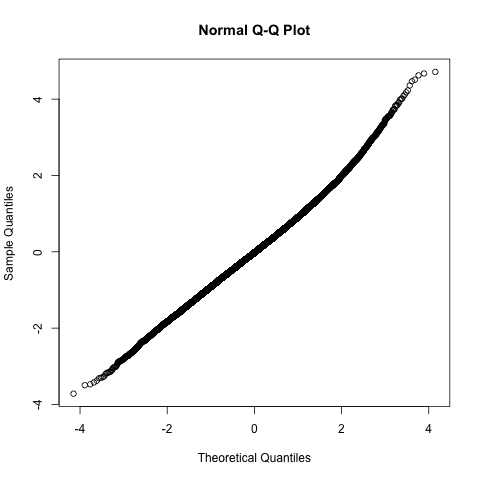

In [45]:
%%R -i peri_binned -o peri_within_anova -o peri_within_model
m <- lmer('df ~ 1+ factor(day)*bout_fraction*factor(cs)*bs(bins, df=8, degree=3) + (1 + bs(bins, df=8, degree=3)|mouse)', data=peri_binned)
peri_within_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
peri_within_anova <- anova(m)

In [46]:
peri_within_anova['Significance'] = peri_within_anova['Pr(>F)'].apply(check_significance)
peri_within_model['Significance'] = peri_within_model['Pr(>|t|)'].apply(check_significance)


display(peri_within_anova, peri_within_model)

supp_train_fig_peri_stats.update({'peri_within_anova': peri_within_anova,
                                  'peri_within_model': peri_within_model
                                  })

Sum Sq    Mean Sq  \
factor(day)                                           0.724151   0.362075   
bout_fraction                                         1.405040   1.405040   
factor(cs)                                            2.547458   2.547458   
bs(bins, df = 8, degree = 3)                         40.576535   5.072067   
factor(day):bout_fraction                             1.572285   0.786142   
factor(day):factor(cs)                                3.199904   1.599952   
bout_fraction:factor(cs)                              1.348117   1.348117   
factor(day):bs(bins, df = 8, degree = 3)             13.385075   0.836567   
bout_fraction:bs(bins, df = 8, degree = 3)          175.670527  21.958816   
factor(cs):bs(bins, df = 8, degree = 3)              19.550540   2.443817   
factor(day):bout_fraction:factor(cs)                  1.421585   0.710793   
factor(day):bout_fraction:bs(bins, df = 8, degr...   24.183373   1.511461   
factor(day):factor(cs):bs(bins, df = 8, degree ...   45.048118   2.815507   
bout_fraction:factor(cs):bs(bins, df = 8, degre...   25.865967   3.233246   
factor(day):bout_fraction:factor(cs):bs(bins, d...   59.412512   3.713282   

                                                    NumDF         DenDF  \
factor(day)                                             2  29879.846879   
bout_fraction                                           1  29890.691823   
factor(cs)                                              1  29883.939145   
bs(bins, df = 8, degree = 3)                            8     26.387342   
factor(day):bout_fraction                               2  29890.677879   
factor(day):factor(cs)                                  2  29875.397073   
bout_fraction:factor(cs)                                1  29890.695144   
factor(day):bs(bins, df = 8, degree = 3)               16  29828.960742   
bout_fraction:bs(bins, df = 8, degree = 3)              8  29890.693179   
factor(cs):bs(bins, df = 8, degree = 3)                 8  29855.674396   
factor(day):bout_fraction:factor(cs)                    2  29890.666249   
factor(day):bout_fraction:bs(bins, df = 8, degr...     16  29890.691327   
factor(day):factor(cs):bs(bins, df = 8, degree ...     16  29794.146434   
bout_fraction:factor(cs):bs(bins, df = 8, degre...      8  29890.693636   
factor(day):bout_fraction:factor(cs):bs(bins, d...     16  29890.689491   

                                                      F value        Pr(>F)  \
factor(day)                                          0.404453  6.673454e-01   
bout_fraction                                        1.569487  2.102913e-01   
factor(cs)                                           2.845615  9.163396e-02   
bs(bins, df = 8, degree = 3)                         5.665708  3.109055e-04   
factor(day):bout_fraction                            0.878153  4.155603e-01   
factor(day):factor(cs)                               1.787213  1.674441e-01   
bout_fraction:factor(cs)                             1.505902  2.197752e-01   
factor(day):bs(bins, df = 8, degree = 3)             0.934480  5.281979e-01   
bout_fraction:bs(bins, df = 8, degree = 3)          24.528902  5.373417e-38   
factor(cs):bs(bins, df = 8, degree = 3)              2.729845  5.234874e-03   
factor(day):bout_fraction:factor(cs)                 0.793985  4.520495e-01   
factor(day):bout_fraction:bs(bins, df = 8, degr...   1.688364  4.139491e-02   
factor(day):factor(cs):bs(bins, df = 8, degree ...   3.145038  2.060944e-05   
bout_fraction:factor(cs):bs(bins, df = 8, degre...   3.611669  3.325374e-04   
factor(day):bout_fraction:factor(cs):bs(bins, d...   4.147889  4.381633e-08   

                                                   Significance  
factor(day)                                                  ns  
bout_fraction                                                ns  
factor(cs)                                                   ns  
bs(bins, df = 8, degree = 3)                                ***  
factor(day):bout_fraction  

Estimate  Std. Error  \
(Intercept)                                         0.045799    0.143664   
factor(day)2                                       -0.142891    0.190064   
factor(day)3                                       -0.215182    0.188274   
bout_fraction                                       0.051791    0.236806   
factor(cs)+                                        -0.011378    0.199850   
...                                                      ...         ...   
factor(day)3:bout_fraction:factor(cs)+:bs(bins,... -0.612909    0.813594   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.619030    0.829699   
factor(day)3:bout_fraction:factor(cs)+:bs(bins,...  1.633510    0.820611   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,... -0.075866    0.660604   
factor(day)3:bout_fraction:factor(cs)+:bs(bins,... -0.198608    0.653368   

                                                              df   t value  \
(Intercept)                                           839.515269  0.318793   
factor(day)2                                        29856.340991 -0.751806   
factor(day)3                                        29849.114053 -1.142919   
bout_fraction                                       29890.611861  0.218707   
factor(cs)+                                         29858.872677 -0.056933   
...                                                          ...       ...   
factor(day)3:bout_fraction:factor(cs)+:bs(bins,...  29890.694639 -0.753334   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  29890.687679  0.746090   
factor(day)3:bout_fraction:factor(cs)+:bs(bins,...  29890.686299  1.990602   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  29890.688989 -0.114843   
factor(day)3:bout_fraction:factor(cs)+:bs(bins,...  29890.679419 -0.303976   

                                                    Pr(>|t|) Significance  
(Intercept)                                         0.749963           ns  
factor(day)2                                        0.452174           ns  
factor(day)3                                        0.253081           ns  
bout_fraction                                       0.826880           ns  
factor(cs)+                                         0.954599           ns  
...                                                      ...          ...  
factor(day)3:bout_fraction:factor(cs)+:bs(bins,...  0.451255           ns  
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.455619           ns  
factor(day)3:bout_fraction:factor(cs)+:bs(bins,...  0.046534            *  
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.908570           ns  
factor(day)3:bout_fraction:factor(cs)+:bs(bins,...  0.761148           ns  

[108 rows x 6 columns]

In [47]:
with pd.ExcelWriter('stats/raw/supp_train_peri_stats.xlsx') as writer:  
    for k,v in supp_train_fig_peri_stats.items():
        v.to_excel(writer, sheet_name=k)

# Testing

In [48]:
# load testing data
testing = analysis(norm_method, t_dur, 
                   ds_freq = 1, ex = ex, detrend = detrend, 
                   detrend_method = detrend_method)
testing.load_append_save(cohort1_data_dir/'testing.npy')
testing.load_append_save(cohort2_data_dir/'testing.npy')
testing.remove_mouse('adm480')

first_lick_test = time_lock_lick(testing, 0)

loading data from file...
loading data from file...


/Users/nathanielnyema/Downloads/photometry-scripts/analysis_pipeline.py:408: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.excluded_raw.append(self.raw_data.xs(pd.IndexSlice[:,mouse], drop_level=False))


recomputing...


/Users/nathanielnyema/Downloads/photometry-scripts/utilities.py:246: RuntimeWarning: invalid value encountered in divide
  normed_405 = (data.F405 - f405_baseline)/f405_baseline
/Users/nathanielnyema/Downloads/photometry-scripts/utilities.py:246: RuntimeWarning: invalid value encountered in divide
  normed_405 = (data.F405 - f405_baseline)/f405_baseline


successful


/Users/nathanielnyema/Downloads/photometry-scripts/analysis_pipeline.py:326: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.err_490=self.all_490.groupby('cond',axis=1).sem()
/Users/nathanielnyema/Downloads/photometry-scripts/analysis_pipeline.py:330: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.err_405=self.all_405.groupby('cond',axis=1).sem()
/Users/nathanielnyema/Downloads/fnc_agrp_project/analysis/photometry/utils.py:206: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or s

### plot time lock mean traces

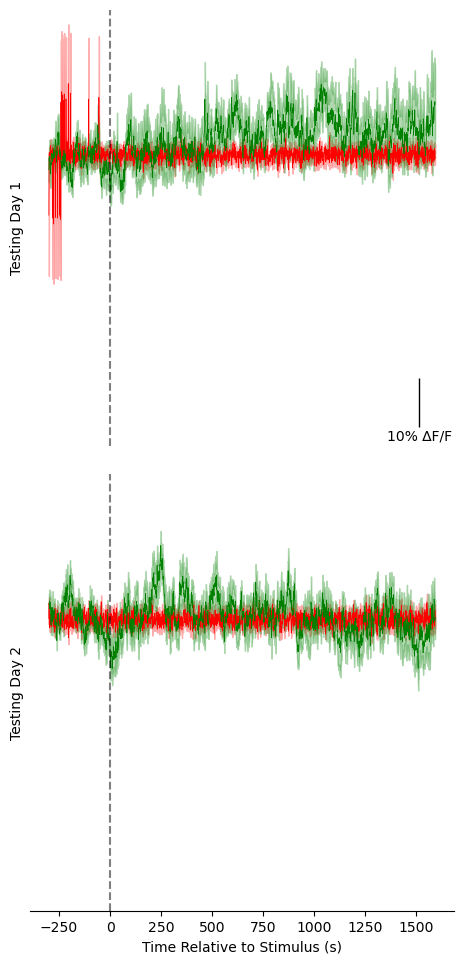

In [49]:
# create subplot
fig, ax = plt.subplots(2,1, figsize = (5,10))
# plot the traces
first_lick_test.plot_both(ax = ax, show = False)
vertbar = AnchoredSizeBar(ax[1].transData,
                           1, '10% ∆F/F', 'lower right', 
                           pad=.1,
                           color='black',
                           frameon=False,
                           size_vertical=.1)
ax[0].add_artist(vertbar)

# format the plots
ax[0].tick_params(left=False,labelleft=False, bottom = False, labelbottom = False)
ax[1].tick_params(left=False,labelleft=False)
sns.despine(ax = ax[0], left = True, bottom = True)
sns.despine(ax = ax[1], left = True)
ax[1].set_ylabel("Testing Day 2")
ax[1].set_title("")
ax[1].set_ylim(-.6,.3)
ax[0].set_ylabel("Testing Day 1")
ax[0].set_title("")
ax[0].set_ylim(-.6,.3)
fig.tight_layout(pad = 2.)
fig.savefig(os.path.join(first_lick_test_pdfs, 'full_trace.pdf'))
fig.savefig(os.path.join(first_lick_test_svgs, 'full_trace.svg'))


In [50]:
#reload the data without normalizing
testing = analysis(norm_method, t_dur, norm = False,
                    ds_freq = ds_freq, ex = ex, detrend = detrend, 
                    detrend_method = detrend_method)
testing.load_append_save(cohort1_data_dir/'testing.npy')
testing.load_append_save(cohort2_data_dir/'testing.npy')
testing.remove_mouse('adm480')

# remove timestamps corresponding to datapoints that will be lost to the moving average
old_t = testing.all_490.index.values
new_t = old_t[int(ds_freq * w_rad):-int(ds_freq *w_rad)]

# estimate baseline with a moving average
bl = testing.all_490.apply(lambda x: pd.Series(signal.convolve(x, kernel, mode='valid'), index = new_t), axis=0)

# update the end and start time fields in the analysis object
testing.t_prestim = -new_t[0]
testing.t_endrec = new_t[-1]
testing.all_490 = testing.all_490.loc[bl.index]

# normalize relative to the baseline
testing.all_490 = (testing.all_490.copy() - bl)/bl

# #z-score ∆F/Fs relative to baseline activity for each session
testing.all_490 = (testing.all_490 - testing.all_490.loc[:0].mean(axis=0))/testing.all_490.loc[:0].std(axis=0)

loading data from file...
loading data from file...


/Users/nathanielnyema/Downloads/photometry-scripts/analysis_pipeline.py:408: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  self.excluded_raw.append(self.raw_data.xs(pd.IndexSlice[:,mouse], drop_level=False))


recomputing...
successful


/Users/nathanielnyema/Downloads/photometry-scripts/analysis_pipeline.py:326: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.err_490=self.all_490.groupby('cond',axis=1).sem()
/Users/nathanielnyema/Downloads/photometry-scripts/analysis_pipeline.py:330: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sem is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  self.err_405=self.all_405.groupby('cond',axis=1).sem()


In [53]:
# compute lick bout times for testing
np.random.seed(99)

setup = pd.read_csv(os.path.join(data_dir,'setup.csv'), index_col = 0)
for i,v in testing.raw_data.items():
    day = i[0][-1]
    mouse = i[1]
    
    # use setup file to identify left v right licks as cs+ v cs- licks
    csp_s = setup.loc[mouse, f'd{day}_side']
    csm_s = 'left' if csp_s == 'right' else 'right'
    testing.raw_data.loc[i].events['csp'] = v.events[csp_s + '_licks']
    testing.raw_data.loc[i].events['csm'] = v.events[csm_s + '_licks']
    
    # combine cs+ and cs- lick times and construct an array of labels
    cspl = testing.raw_data.loc[i].events['csp']
    csml = testing.raw_data.loc[i].events['csm'] 
    all_licks = np.concatenate((cspl, csml))
    labels = np.array(['p']*cspl.size + ['m']*csml.size)
    
    # sort labels for all lick events so we can identify bouts later
    sort_idx = all_licks.argsort()
    labels = labels[sort_idx]
    all_licks = all_licks[sort_idx]
    
    # identify bout starts by thresholding the ili over all licks
    ili = np.append(bout_thresh + 1, all_licks[1:] - all_licks[:-1] )
    all_bouts = all_licks[ili>bout_thresh]
    
    # determine whether bouts were initiated by a cs+ or cs- lick
    all_bout_labels = labels[ili>bout_thresh]
    csp_bouts = all_bouts[all_bout_labels == 'p']
    csm_bouts = all_bouts[all_bout_labels == 'm']
    
    # update the field
    testing.raw_data.loc[i].events['all_csp_bouts'] = csp_bouts
    testing.raw_data.loc[i].events['all_csm_bouts'] = csm_bouts
    
    
    # remove bouts near the end that cannot be used for peri-bout analyses
    csp_bn = get_bn(testing.raw_data.loc[i], 'csp', 'all_csp_bouts').values
    csp_bouts = csp_bouts[csp_bn>1]
    csp_bouts = csp_bouts[csp_bouts<testing.t_endrec - peri_window - 1]
    
    csm_bn = get_bn(testing.raw_data.loc[i], 'csm', 'all_csm_bouts').values
    csm_bouts = csm_bouts[csm_bn>1]
    csm_bouts = csm_bouts[csm_bouts<testing.t_endrec - peri_window - 1]
    
    testing.raw_data.loc[i].events['csp_bouts'] = csp_bouts
    testing.raw_data.loc[i].events['csm_bouts'] = csm_bouts
    
    testing.raw_data.loc[i].events['all_bouts'] = all_bouts  

In [54]:
# check how many bouts we are removing due to the moving average
max_rm_bouts = testing.raw_data.map(lambda x: (x.events['all_bouts']>testing.t_endrec).sum()).max()
mn_rm_bouts = testing.raw_data.map(lambda x: (x.events['all_bouts']>testing.t_endrec).sum()).mean()
print('max removed bouts:', max_rm_bouts , '\nmn_rm_bouts:', mn_rm_bouts)

max removed bouts: 1 
mn_rm_bouts: 0.3333333333333333


In [55]:
# # get peri-bout activity for all cs+ and cs- bouts
    
csp_bout = peri_event(testing, 'csp_bouts', peri_window, norm = peri_bout_norm_test).T
csm_bout = peri_event(testing, 'csm_bouts', peri_window, norm = peri_bout_norm_test).T

# combine into one dataframe
peri_test = pd.concat({'+':csp_bout, '-':csm_bout}, names = ['cs'])
peri_test.columns.name = 'time'

# some reformatting for easier access
peri_test = peri_test.stack().rename('df').reset_index()
peri_test['day'] = peri_test.cond.str.extract('_(.)').astype(int)
peri_test = peri_test.set_index(['day','cs','mouse', 'event', 'time']).df.unstack('time')

# select only mice that had at least 3 bouts for each flavor on both days
nb_test = peri_test.groupby(['cs','day','mouse']).size().unstack(['cs','day'])
good_mice = (nb_test>=3).all(axis=1)
good_mice = good_mice.loc[good_mice].index
nb_test = nb_test.loc[good_mice].stack(['cs','day'])
peri_test = (peri_test.swaplevel('day','mouse')
                      .loc[good_mice]
                      .swaplevel('day','mouse')
            )

# get mean response
mn_peri_test = peri_test.groupby(['day','cs','mouse']).mean()
mn_peri_test = (mn_peri_test.unstack(['day','cs'])
                            .dropna()
                            .stack(['cs', 'day'])
                            .swaplevel('mouse','day')
                            .sort_index()
               )

In [56]:

# seed the random number generator for random bout generation
np.random.seed(5)

# simmulate random lick bouts and get corresponding peri bout activity
ctl_test = []

with tqdm(total = niters_rand) as pbar:
    def randomize_test_bouts(pid):
        global ctl_test
        global testing
        end_lim = testing.all_490.index[-1]-peri_window-1
        for i,v in testing.raw_data.items():
            # create an array of times to sample
            ts = np.arange(0, end_lim + 1/100, step = 1/100)
            n = v.events['all_bouts'].size # get the number of bouts to sample
            rand_evs = np.empty((n,))
            for j in range(n):
                #choose a bout onset time from available times
                rand_evs[j] = np.random.choice(ts)
                # remove the selected time from avavilable times array
                # as well as any times within the bout threshold
                ts = ts[np.abs(ts - rand_evs[j]) > bout_thresh]  
            rand_evs = np.sort(rand_evs) 
            # sample appropriate number of cs+ bouts
            csp = np.random.choice(rand_evs, v.events['all_csp_bouts'].size, replace = False)
            rand_evs = rand_evs[~np.isin(rand_evs, csp)]
            csp = np.random.choice(csp, v.events['csp_bouts'].size, replace = False)

            # sample appropriate number of cs- bouts
            csm = np.random.choice(rand_evs, v.events['all_csm_bouts'].size, replace = False)
            csm = np.random.choice(csm, v.events['csm_bouts'].size, replace = False)

            #save randomized bouts
            testing.raw_data.loc[i].events[f'rand_csp_{pid}'] = csp
            testing.raw_data.loc[i].events[f'rand_csm_{pid}'] = csp

        # get peri-bout data for random bouts and compute the mean response
        _d = pd.concat({'+': peri_event(testing, f'rand_csp_{pid}',  
                                        peri_window, 
                                        norm = peri_bout_norm_test).groupby(['cond','mouse'], axis=1).mean(),
                        '-': peri_event(testing, f'rand_csm_{pid}', 
                                        peri_window, 
                                        norm = peri_bout_norm_test).groupby(['cond','mouse'], axis=1).mean()
                       }, names = ['cs','time'])
        

        ctl_test.append(_d)


    with ThreadPoolExecutor(max_workers=2) as pool:
        futures = [pool.submit(randomize_test_bouts, i) for i in range(niters_rand)]
        for future in as_completed(futures):
            pbar.update(1)
        
ctl_test = pd.concat(dict(enumerate(ctl_test)), axis=1, names = ['event'])
ctl_test = ctl_test.unstack('cs').T.reset_index()
ctl_test['day']= ctl_test.cond.str.extract('_(.)').astype(int)
ctl_test=ctl_test.set_index(['day','cs','mouse','event']).drop('cond', axis=1).sort_index()
ctl_test_mn = ctl_test.groupby(['day','cs','mouse']).mean()


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  9.01it/s]


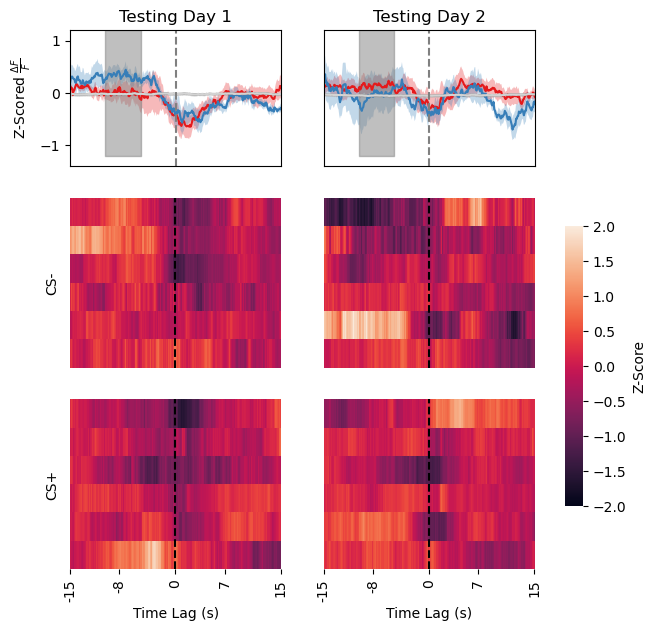

In [57]:
fig, ax = plot_peri( mn_peri_test, ctl_test_mn, 'Testing', peri_stim_test_figs,
                    'testing_all', figsize = (6,7), ylim = (-1.4,1.2), vmin = -2, vmax = 2, 
                    vlabel= r'Z-Score', ylabel =  r'Z-Scored $\frac{\Delta F}{F}$', save = False,);

for i in range(2):
    ax[0,i].fill_between([-10,-5], -1.2,1.2,color='gray', alpha=0.5)

fig.savefig(os.path.join(peri_stim_pdfs_test ,'test_peri.pdf'))
fig.savefig(os.path.join(peri_stim_svgs_test ,'test_peri.svg'))


#### individual mice

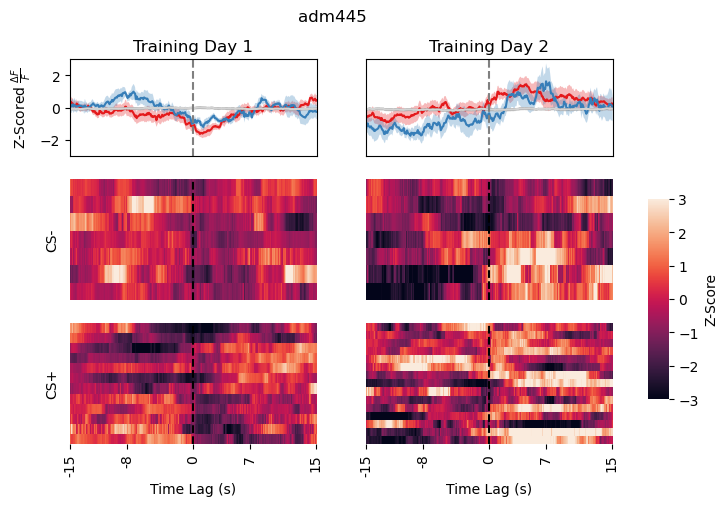

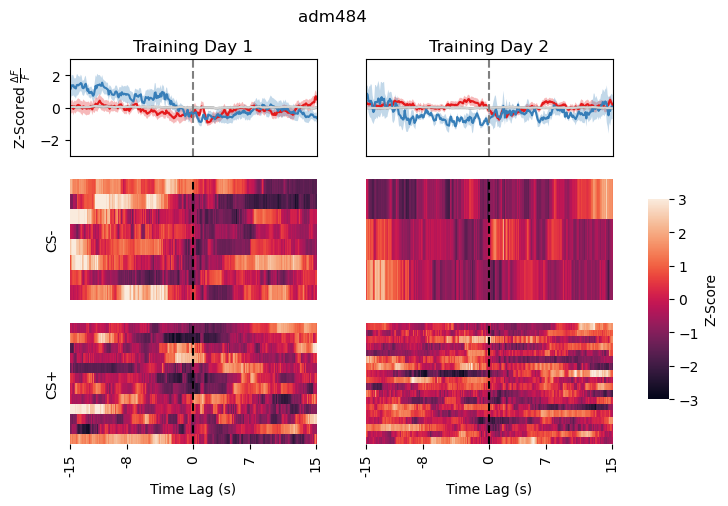

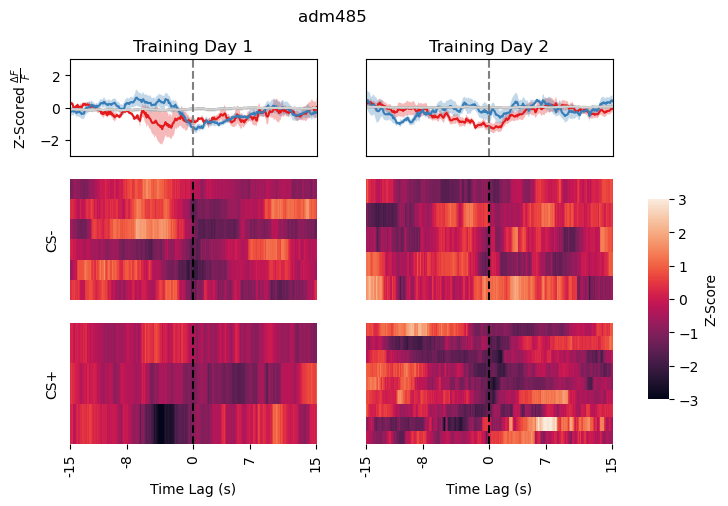

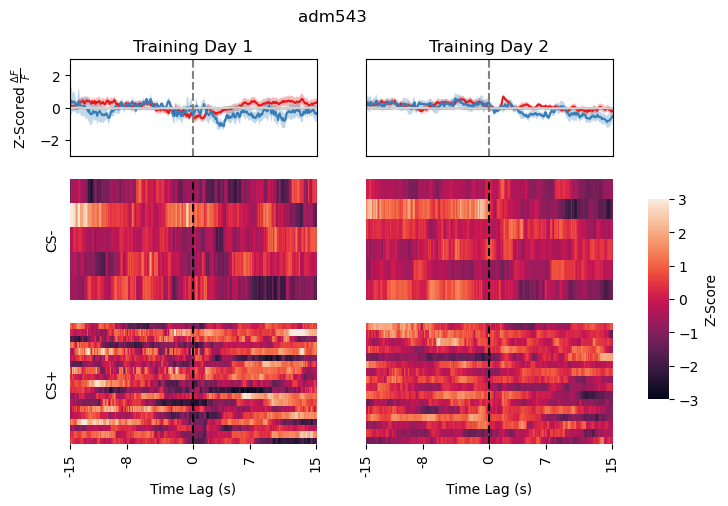

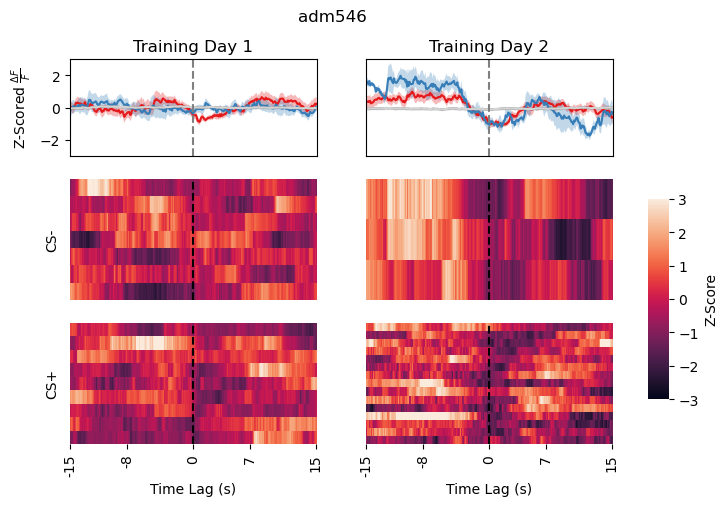

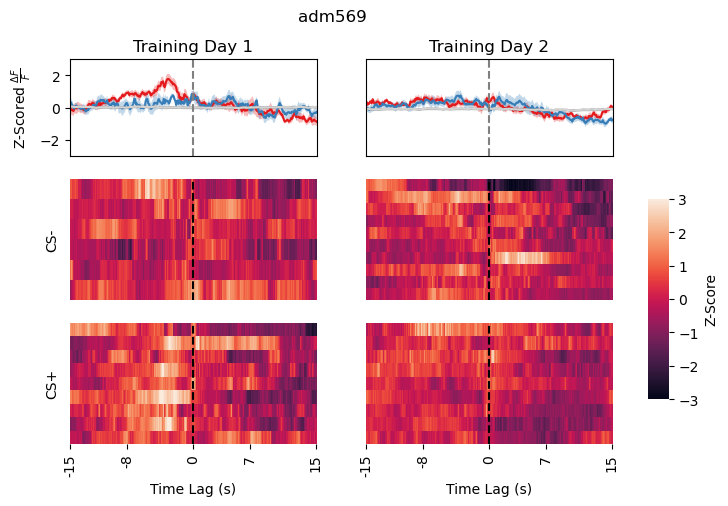

In [58]:
for i in mn_peri_test.index.get_level_values('mouse').unique():
    fig, _ = plot_peri(peri_test.swaplevel('day','mouse').loc[i].swaplevel('day','cs'), 
                        ctl = ctl_test.swaplevel('day','mouse').loc[i].swaplevel('day','cs'),
                        save=False, vmin = -3, vmax=3, ylim = (-3,3));
    fig.suptitle(i)
    os.makedirs(os.path.join(peri_stim_pdfs_test , i), exist_ok=True)  
    os.makedirs(os.path.join(peri_stim_svgs_test , i), exist_ok=True)   

    fig.savefig(os.path.join(peri_stim_pdfs_test , i,  'test_peri.pdf'), bbox_inches = 'tight')
    fig.savefig(os.path.join(peri_stim_svgs_test , i, 'test_peri.svg'), bbox_inches = 'tight')


#### stats

##### stats - compare lick bouts to be sure the corresponding bout numbers for all bout triggered averages are comparable

In [59]:
nbouts = (nb_test.groupby(['day','cs']).mean().round(2).astype(str) + ' ± ' + nb_test.groupby(['day','cs']).sem().round(2).astype(str)).rename('bout number').to_frame()
display(nbouts)
main_test_fig_stats.update({'a_n_bouts': nbouts})

bout number
day cs              
1   +   10.67 ± 2.14
    -     6.5 ± 0.43
2   +   13.67 ± 1.54
    -    5.67 ± 1.09

##### stats - compare bout triggered averages

In [60]:
peri_test_binned = bin_peri_bout(peri_test, 1).stack().rename('df').reset_index()

R[write to console]: boundary (singular) fit: see help('isSingular')



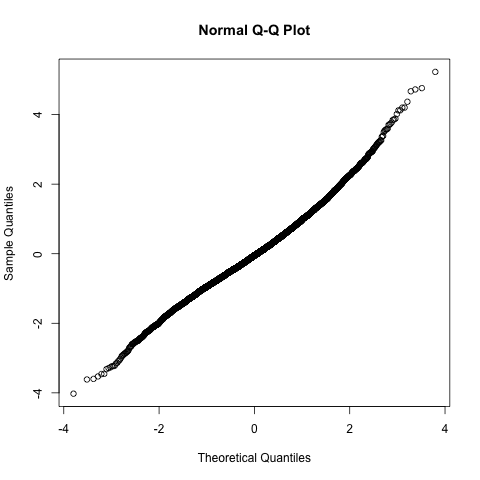

In [61]:
%%R -i peri_test_binned  -o test_anova  -o test_model
#-o test_per_day
m <- lmer('df ~ 1 + factor(day)*bs(bins, df=6,degree=3)*factor(cs) + (1 + bs(bins, df=6,degree=3)|mouse)', data = peri_test_binned)
test_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
test_anova <- anova(m)

In [62]:
test_anova['Significance'] = test_anova['Pr(>F)'].apply(check_significance)
test_model['Significance'] = test_model['Pr(>|t|)'].apply(check_significance)

display(test_anova, test_model)
main_test_fig_stats.update({'a_test_anova_trace': test_anova,
                            'a_test_model' : test_model
                     })

Sum Sq    Mean Sq  \
factor(day)                                          1.143471   1.143471   
bs(bins, df = 6, degree = 3)                        17.896238   2.982706   
factor(cs)                                           0.203752   0.203752   
factor(day):bs(bins, df = 6, degree = 3)            65.052014  10.842002   
factor(day):factor(cs)                               0.588140   0.588140   
bs(bins, df = 6, degree = 3):factor(cs)             24.090321   4.015053   
factor(day):bs(bins, df = 6, degree = 3):factor...  22.991606   3.831934   

                                                    NumDF        DenDF  \
factor(day)                                             1  6721.942643   
bs(bins, df = 6, degree = 3)                            6     7.348296   
factor(cs)                                              1  6428.916105   
factor(day):bs(bins, df = 6, degree = 3)                6  6709.677415   
factor(day):factor(cs)                                  1  6526.278086   
bs(bins, df = 6, degree = 3):factor(cs)                 6  6205.540225   
factor(day):bs(bins, df = 6, degree = 3):factor...      6  6371.131504   

                                                      F value        Pr(>F)  \
factor(day)                                          1.082403  2.981980e-01   
bs(bins, df = 6, degree = 3)                         2.823413  9.572657e-02   
factor(cs)                                           0.192871  6.605529e-01   
factor(day):bs(bins, df = 6, degree = 3)            10.262978  2.431741e-11   
factor(day):factor(cs)                               0.556730  4.556078e-01   
bs(bins, df = 6, degree = 3):factor(cs)              3.800627  8.775454e-04   
factor(day):bs(bins, df = 6, degree = 3):factor...   3.627287  1.353149e-03   

                                                   Significance  
factor(day)                                                  ns  
bs(bins, df = 6, degree = 3)                                 ns  
factor(cs)                                                   ns  
factor(day):bs(bins, df = 6, degree = 3)                   ****  
factor(day):factor(cs)                                       ns  
bs(bins, df = 6, degree = 3):factor(cs)                     ***  
factor(day):bs(bins, df = 6, degree = 3):factor...           **

Estimate  Std. Error  \
(Intercept)                                         0.328253    0.180213   
factor(day)2                                       -0.232805    0.212479   
bs(bins, df = 6, degree = 3)1                      -0.262997    0.298071   
bs(bins, df = 6, degree = 3)2                       0.657678    0.246864   
bs(bins, df = 6, degree = 3)3                      -1.172366    0.403624   
bs(bins, df = 6, degree = 3)4                      -0.218265    0.347112   
bs(bins, df = 6, degree = 3)5                      -0.559260    0.282812   
bs(bins, df = 6, degree = 3)6                      -0.703127    0.264724   
factor(cs)+                                        -0.154660    0.184050   
factor(day)2:bs(bins, df = 6, degree = 3)1         -0.221854    0.410696   
factor(day)2:bs(bins, df = 6, degree = 3)2         -0.595250    0.314016   
factor(day)2:bs(bins, df = 6, degree = 3)3          0.645951    0.353087   
factor(day)2:bs(bins, df = 6, degree = 3)4          0.569704    0.340425   
factor(day)2:bs(bins, df = 6, degree = 3)5         -0.393539    0.355293   
factor(day)2:bs(bins, df = 6, degree = 3)6          0.447538    0.298065   
factor(day)2:factor(cs)+                            0.194672    0.260904   
bs(bins, df = 6, degree = 3)1:factor(cs)+          -0.106589    0.355618   
bs(bins, df = 6, degree = 3)2:factor(cs)+          -0.217199    0.272214   
bs(bins, df = 6, degree = 3)3:factor(cs)+          -0.014863    0.306147   
bs(bins, df = 6, degree = 3)4:factor(cs)+           0.425209    0.295134   
bs(bins, df = 6, degree = 3)5:factor(cs)+           0.225093    0.307721   
bs(bins, df = 6, degree = 3)6:factor(cs)+           0.732714    0.258145   
factor(day)2:bs(bins, df = 6, degree = 3)1:fact...  0.355104    0.504002   
factor(day)2:bs(bins, df = 6, degree = 3)2:fact...  0.513649    0.386117   
factor(day)2:bs(bins, df = 6, degree = 3)3:fact... -0.003250    0.434258   
factor(day)2:bs(bins, df = 6, degree = 3)4:fact... -0.419339    0.418634   
factor(day)2:bs(bins, df = 6, degree = 3)5:fact...  0.306458    0.436188   
factor(day)2:bs(bins, df = 6, degree = 3)6:fact... -0.654637    0.365900   

                                                             df   t value  \
(Intercept)                                           24.548411  1.821466   
factor(day)2                                        6635.256743 -1.095660   
bs(bins, df = 6, degree = 3)1                         84.376361 -0.882330   
bs(bins, df = 6, degree = 3)2                         35.792853  2.664130   
bs(bins, df = 6, degree = 3)3                          9.651468 -2.904598   
bs(bins, df = 6, degree = 3)4                         12.661809 -0.628802   
bs(bins, df = 6, degree = 3)5                         35.509104 -1.977498   
bs(bins, df = 6, degree = 3)6                         19.728911 -2.656077   
factor(cs)+                                         6574.557313 -0.840317   
factor(day)2:bs(bins, df = 6, degree = 3)1          6660.053030 -0.540191   
factor(day)2:bs(bins, df = 6, degree = 3)2          6270.524082 -1.895606   
factor(day)2:bs(bins, df = 6, degree = 3)3          6536.304171  1.829437   
factor(day)2:bs(bins, df = 6, degree = 3)4          6379.681555  1.673511   
factor(day)2:bs(bins, df = 6, degree = 3)5          6600.148819 -1.107648   
factor(day)2:bs(bins, df = 6, degree = 3)6          6699.343889  1.501481   
factor(day)2:factor(cs)+                            6526.278086  0.746143   
bs(bins, df = 6, degree = 3)1:factor(cs)+           6614.601841 -0.299729   
bs(bins, df = 6, degree = 3)2:factor(cs)+           6018.036003 -0.797898   
bs(bins, df = 6, degree = 3)3:factor(cs)+           6419.214607 -0.048549   
bs(bins, df = 6, degree = 3)4:factor(cs)+           6181.349273  1.440735   
bs(bins, df = 6, degree = 3)5:factor(cs)+           6520.988403  0.731485   
bs(bins, df = 6, degree = 3)6:factor(cs)+           6674.654516  2.838384   
factor(day)2:bs(bins, df = 6, degree = 3)1:fact...  6575.700815  0.704569   

### further quantification

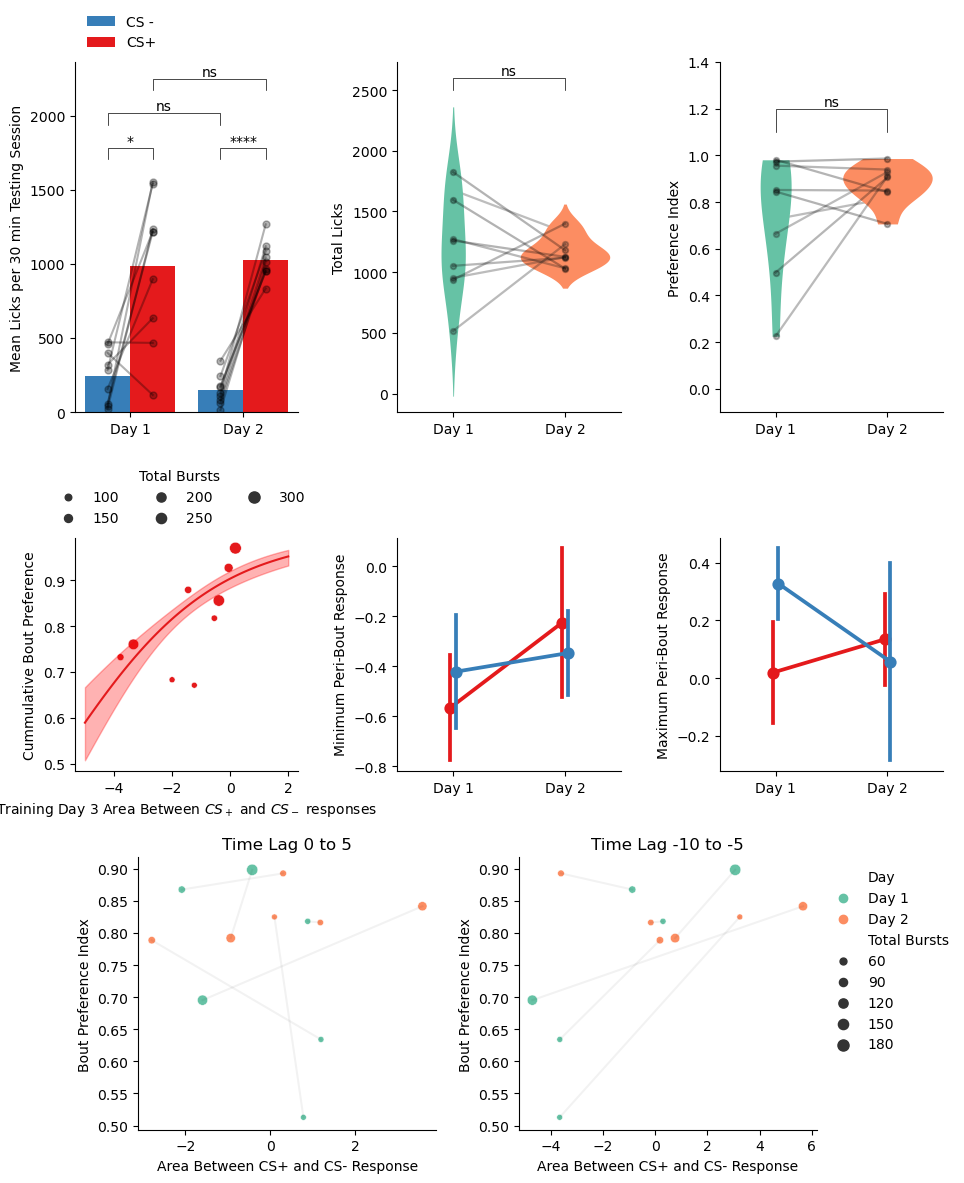

In [63]:
def get_cs_licks(x):
    x = x.iloc[0]
    return pd.Series([x.events['csp'].size, x.events['csm'].size], 
                     index = pd.Index(('+', '-'), name = 'cs'))
def get_cs_bursts(x):
    x = x.iloc[0]
    csp_ili = np.append(1, x.events['csp'][1:] - x.events['csp'][:-1])
    csm_ili = np.append(1, x.events['csm'][1:] - x.events['csm'][:-1])
    return pd.Series([(csp_ili>0.5).sum(), (csm_ili>0.5).sum()], 
                     index = pd.Index(('+', '-'), name = 'cs'))

# get testing licks for plot
licks_test_d = testing.raw_data.groupby(['cond','mouse']).apply(get_cs_licks).rename('licks').reset_index().rename(columns = {'cs': 'CS'})
licks_test_d['day'] = licks_test_d.cond.str.split('_',expand = True)[1].astype(int)
licks_test_d = licks_test_d.set_index(['day','mouse','CS']).licks.rename('total_licks')


# get testing bursts
burst_test_d = testing.raw_data.groupby(['cond','mouse']).apply(get_cs_bursts).rename('bursts').reset_index().rename(columns = {'cs': 'CS'})
burst_test_d['day'] = burst_test_d.cond.str.split('_',expand = True)[1].astype(int)
burst_test_d = burst_test_d.set_index(['day','mouse','CS']).bursts.rename("bursts")
day_df = pd.concat({'pref': burst_test_d.unstack("CS")['+']/(burst_test_d.unstack("CS")['+'] + burst_test_d.unstack("CS")['-']),
                    'tot': burst_test_d.unstack("CS")['+'] + burst_test_d.unstack("CS")['-']}, axis=1)

cumm_pref = burst_test_d.unstack('CS').groupby(['mouse']).sum().apply(lambda x: x['+']/(x['+']+x['-']), axis=1)
tot = burst_test_d.unstack('CS').groupby(['mouse']).sum().apply(lambda x: (x['+']+x['-']), axis=1)


# get the min from 0-5
mn_loc =  mn_peri_test.groupby(['day','cs']).mean().T.loc[0:5].idxmin(axis=0)
mn_rp_test_post = {}
for i,v in mn_loc.items():
    tmp = mn_peri_test.loc[i].T
    tmp.index = tmp.index.astype(float)
    mn_rp_test_post.update({i:tmp.loc[v-1:v+1].mean(axis=0)})
mn_rp_test_post = pd.DataFrame(mn_rp_test_post).T
mn_rp_test_post.index = mn_rp_test_post.index.set_names(['day', 'cs'])
mn_rp_test_post = mn_rp_test_post.stack().rename('df')


# get the max from -10- -5
mx_loc =  mn_peri_test.groupby(['day','cs']).mean().T.loc[-10:-5].idxmax(axis=0)
mx_rp_test = {}
for i,v in mx_loc.items():
    tmp = mn_peri_test.loc[i].T
    tmp.index = tmp.index.astype(float)
    mx_rp_test.update({i:tmp.loc[v-1:v+1].mean(axis=0)})
mx_rp_test = pd.DataFrame(mx_rp_test).T
mx_rp_test.index = mx_rp_test.index.set_names(['day', 'cs'])
mx_rp_test= mx_rp_test.stack().rename('df')


# get areas between curves
day_df['abc_10_5'] = (mn_peri_test.T.loc[-10:-5].T.stack().unstack('cs')
                                  .apply(lambda x: x['+'] - x['-'], axis=1)
                                  .unstack('time')
                                  .apply(lambda x: np.trapz(x=x.index, y=x), axis=1)
                                  .rename('abc')
                     )
day_df['abc_0_5'] = (mn_peri_test.T.loc[0:5].T.stack().unstack('cs')
                                  .apply(lambda x: x['+'] - x['-'], axis=1)
                                  .unstack('time')
                                  .apply(lambda x: np.trapz(x=x.index, y=x), axis=1)
                                  .rename('abc')
                     )



# create subplot
fig,ax = plt.subplots(3,3, figsize = (10,12), gridspec_kw = {'height_ratios': [1.5,1,1]})
# plot testing licks on each day
_, stats_2b  = two_bottle_plot(licks_test_d.loc[2].to_frame(), licks_test_d.loc[1].to_frame(), 
                               groups = ['Day 2', 'Day 1'], ax=ax[0,0], all_paired = True,
                               palette = sns.color_palette('Set1',2))

# plot total testing bursts
tmp = licks_test_d.unstack('CS').sum(axis=1).unstack('day')
ttest_res = st.ttest_rel(tmp[1], tmp[2])
cumm_stat = pd.DataFrame({'paired ttest': list(ttest_res) + [ttest_res.df]}, index= ('t', 'p-value', 'df')).T
tmp = tmp.stack('day').rename('tot').reset_index()
sns.pointplot(data = tmp, x = 'day', y = 'tot',
              hue = 'mouse', color='k', ax = ax[0,1], scale= .6)
plt.setp(ax[0,1].lines, alpha=.3)
plt.setp(ax[0,1].collections, alpha=.3)
plot_significance(cumm_stat['p-value'].iloc[0], ax[0,1], 0, 1, 2500, 100 )
sns.violinplot(data = tmp, x = 'day', y = 'tot',  ax = ax[0,1], linewidth=0, saturation = 1, palette = 'Set2')
ax[0,1].get_legend().remove()
ax[0,1].set_xticks([0,1], labels = ['Day 1', 'Day 2'])
ax[0,1].set_xlabel('')
ax[0,1].set_ylabel("Total Licks")

# plot preference indices on each day
tmp = licks_test_d.unstack('CS')
tmp = tmp['+']/(tmp['+'] + tmp['-'])
tmp = tmp.unstack('day')
pref_stat = pd.DataFrame({'signed rank': st.wilcoxon(tmp[1], tmp[2])}, index= ('W', 'p-value')).T
tmp = tmp.stack('day').rename('pref').reset_index()
sns.pointplot(data = tmp, x = 'day', y = 'pref',
              hue = 'mouse', color='k', ax = ax[0,2], scale= .6)
plt.setp(ax[0,2].lines, alpha=.3)
plt.setp(ax[0,2].collections, alpha=.3)
plot_significance(pref_stat['p-value'].iloc[0], ax[0,2], 0, 1, 1.1, .1 )
sns.violinplot(data = tmp, x = 'day', y = 'pref',  ax = ax[0,2], linewidth=0, saturation = 1, palette = 'Set2', cut=0)
ax[0,2].set_ylim([-.1,1.4])
ax[0,2].get_legend().remove()
ax[0,2].set_xticks([0,1], labels = ['Day 1', 'Day 2'])
ax[0,2].set_xlabel('')
ax[0,2].set_ylabel("Preference Index")


# plot pref vs train day 3 response
df = pd.concat({'preference':cumm_pref ,'training_day3_diff': diff_d3.loc[cumm_pref.index], 'total_bursts': tot})
sns.scatterplot(df, x='training_day3_diff', y='preference', size='total_bursts', ax=ax[1,0])
train_v_pref_model = smf.glm("preference ~ training_day3_diff", data = df, family = sm.families.Binomial(), freq_weights = df.total_bursts).fit()
x = np.linspace(-5, 2, 100)
pred = train_v_pref_model .get_prediction({'training_day3_diff': x})
ax[1,0].plot(x, pred.predicted_mean)
ax[1,0].fill_between(x, pred.conf_int()[:,0], pred.conf_int()[:,1],alpha=0.3, color='red')
ax[1,0].legend(frameon=False, title = 'Total Bursts', ncols=3, bbox_to_anchor=(-.15,1),loc='lower left')
ax[1,0].set(ylabel=r"Cummulative Bout Preference", xlabel="Training Day 3 Area Between $CS_+$ and $CS_-$ responses")



# plot minimum peri response on each day
sns.pointplot(mn_rp_test_post.reset_index(), x='day', y='df',hue='cs',errorbar='se',dodge=True, ax=ax[1,1])
ax[1,1].get_legend().remove()
ax[1,1].set_ylabel("Minimum Peri-Bout Response")
ax[1,1].set_xticks([0,1], labels = ['Day 1', 'Day 2'])
ax[1,1].set_xlabel("")


# plot maximum peri response on each day
sns.pointplot(mx_rp_test.reset_index(), x='day', y='df',hue='cs',errorbar='se',dodge=True, ax=ax[1,2])
ax[1,2].get_legend().remove()
ax[1,2].set_ylabel("Maximum Peri-Bout Response")
ax[1,2].set_xticks([0,1], labels = ['Day 1', 'Day 2'])
ax[1,2].set_xlabel("")


# plot pref vs difference in cs+ and cs- tuning on each day
fig.tight_layout(pad = 2.)
ax[2,0].remove()
ax[2,1].remove()
ax[2,2].remove()
 
from matplotlib.gridspec import GridSpec
gs = GridSpec(3,14)
ax = fig.add_subplot(gs[2,1:6])

_day_df = day_df.reset_index()
_day_df['Day'] = 'Day ' + _day_df.day.astype('str')
_day_df = _day_df.rename(columns = {'tot': 'Total Bursts'})
sns.lineplot(data = _day_df, x = 'abc_0_5', y = 'pref', hue = 'mouse', legend = False,
             palette = ["k"]* day_df.reset_index().mouse.unique().size, ax = ax, alpha=.05)
sns.scatterplot(data = _day_df, x = 'abc_0_5', y = 'pref', hue = 'Day', 
                ax = ax, palette = 'Set2', s=50, size = 'Total Bursts')

h, l = ax.get_legend_handles_labels()
ax.get_legend().remove()
ax.set_title("Time Lag 0 to 5")
ax.set_xlabel(r"Area Between CS+ and CS- Response")
ax.set_ylabel("Bout Preference Index")

ax = fig.add_subplot(gs[2,7:12])
_day_df = day_df.reset_index()
_day_df['Day'] = 'Day ' + _day_df.day.astype('str')
_day_df = _day_df.rename(columns = {'tot': 'Total Bursts'})
sns.lineplot(data = _day_df, x = 'abc_10_5', y = 'pref', hue = 'mouse', legend = False,
             palette = ["k"]* day_df.reset_index().mouse.unique().size, ax = ax, alpha=.05)
sns.scatterplot(data = _day_df, x = 'abc_10_5', y = 'pref', hue = 'Day', 
                ax = ax, palette = 'Set2', s=50, size = 'Total Bursts')

h, l = ax.get_legend_handles_labels()
ax.legend(h, l, frameon = False, loc = 'upper left', bbox_to_anchor = (1,1))
ax.set_title("Time Lag -10 to -5")
ax.set_xlabel(r"Area Between CS+ and CS- Response")
ax.set_ylabel("Bout Preference Index")

# format the figure
sns.despine()


# # save the figure
fig.savefig(os.path.join(peri_stim_pdfs_test ,'test_pref_quant.pdf'))
fig.savefig(os.path.join(peri_stim_svgs_test ,'test_pref_quant.svg'))

#### stats

##### stats - 2 bottle stats

In [64]:
shapiro = (licks_test_d.groupby(['day','CS'])
             .apply(lambda x: pd.Series(st.shapiro(x), index = ('statistic', 'p-value')))
             .unstack()
          )
anova_res = AnovaRM(licks_test_d.reset_index(), 'total_licks',  'mouse', within = ['CS','day']).fit().summary().tables[0]
anova_res['Significance'] = anova_res['Pr > F'].apply(check_significance)
stats_2b = stats_2b.rename(columns = {'pvalue': 'p-value', 'pvalue_corr': 'Corrected p-value', 'statistic': 't'})
stats_2b['Significance'] = stats_2b['Corrected p-value'].apply(check_significance)
display(shapiro, anova_res, stats_2b)

main_test_fig_stats.update({'c_test_anova_g'   : anova_res,
                            'c_test_posthoc_g' : stats_2b})

statistic   p-value
day CS                     
1   +    0.922830  0.416183
    -    0.888802  0.193942
2   +    0.965658  0.855264
    -    0.957940  0.776536

F Value  Num DF  Den DF    Pr > F Significance
CS      81.540858     1.0     8.0  0.000018         ****
day      0.143500     1.0     8.0  0.714682           ns
CS:day   0.310387     1.0     8.0  0.592683           ns

t       p-value  Corrected p-value  df  \
CS+ vs. CS- Day 2        14.030080  6.462966e-07           0.000003   8   
CS+ vs. CS- Day 1         3.601283  6.969304e-03           0.020763   8   
CS+ Day 2 vs. CS+ Day 1   0.202887  8.442883e-01           0.975754   8   
CS- Day 2 vs. CS- Day 1   0.202887  8.442883e-01           0.975754   8   

                         paired Significance  
CS+ vs. CS- Day 2          True         ****  
CS+ vs. CS- Day 1          True            *  
CS+ Day 2 vs. CS+ Day 1    True           ns  
CS- Day 2 vs. CS- Day 1    True           ns

##### stats - cummulative licks comparison

In [65]:
cumm_stat['Significance'] = cumm_stat['p-value'].apply(check_significance)
display(cumm_stat)
main_test_fig_stats.update({'d_cumm_licks_d1v2': cumm_stat})

t   p-value   df Significance
paired ttest  0.378814  0.714682  8.0           ns

##### stats - preference comparison

In [66]:
pref_stat['Significance'] = pref_stat['p-value'].apply(check_significance)
display(pref_stat)
main_test_fig_stats.update({'e_pref_d1v2': pref_stat})

W   p-value Significance
signed rank  15.0  0.425781           ns

##### stats - training area between curves vs preference

In [68]:
train_v_pref = pd.DataFrame(train_v_pref_model.summary().tables[1]).astype(str)
train_v_pref.columns = train_v_pref.iloc[0].astype(str)
train_v_pref[''] = train_v_pref[''].astype(str)
train_v_pref = train_v_pref.iloc[1:].set_index('').astype(float)
train_v_pref['Significance'] = train_v_pref['P>|z|'].apply(check_significance)
display(train_v_pref)
main_test_fig_stats.update({'f_pref_v_train_abc_d3': train_v_pref})

0                     coef  std err       z  P>|z|  [0.025  0.975]  \
                                                                     
Intercept           2.2370    0.106  21.021    0.0   2.028   2.446   
training_day3_diff  0.3753    0.047   8.032    0.0   0.284   0.467   

0                  Significance  
                                 
Intercept                  ****  
training_day3_diff         ****

##### stats - minimum comparison

In [69]:
min_stats = pd.concat({'CS+ vs CS-': mn_rp_test_post.unstack('cs')
                                                    .groupby('day')
                                                    .apply(lambda x: st.ttest_rel(x['+'], x['-']))
                                                    .apply(lambda x: pd.Series(list(x) + [x.df], index=('t', 'p-value', 'df')))
                                                    .reset_index(),
                       'Day 1 vs Day 2': mn_rp_test_post.unstack('day')
                                                        .groupby('cs')
                                                        .apply(lambda x: st.ttest_rel(x[1], x[2]))
                                                        .apply(lambda x: pd.Series(list(x) + [x.df], index=('t', 'p-value', 'df')))
                                                        .reset_index()
                      }, names = ['Comparison']).droplevel(1).reset_index()
min_stats['Corrected p-value'] = multipletests(min_stats['p-value'], method = 'holm-sidak')[1]
min_stats['Significance'] = min_stats['Corrected p-value'].apply(check_significance)
main_test_fig_stats.update({'g_min_resp_d1v2': min_stats})
display(min_stats)

Comparison  day         t   p-value   df   cs  Corrected p-value  \
0      CS+ vs CS-  1.0 -1.092708  0.324352  5.0  NaN           0.791607   
1      CS+ vs CS-  2.0  0.457509  0.666498  5.0  NaN           0.888777   
2  Day 1 vs Day 2  NaN -0.913352  0.402950  5.0    +           0.791607   
3  Day 1 vs Day 2  NaN -0.313847  0.766309  5.0    -           0.888777   

  Significance  
0           ns  
1           ns  
2           ns  
3           ns

##### stats - mean comparison

In [70]:
mean_stats = pd.concat({'CS+ vs CS-': mx_rp_test.unstack('cs')
                                                .groupby('day')
                                                .apply(lambda x: st.ttest_rel(x['+'], x['-']))
                                                .apply(lambda x: pd.Series(list(x) + [x.df], index=('t', 'p-value', 'df')))
                                                .reset_index(),
                       'Day 1 vs Day 2': mx_rp_test.unstack('day')
                                                   .groupby('cs')
                                                   .apply(lambda x: st.ttest_rel(x[1], x[2]))
                                                   .apply(lambda x: pd.Series(list(x) + [x.df], index=('t', 'p-value', 'df')))
                                                   .reset_index()
                      }, names = ['Comparison']).droplevel(1).reset_index()
mean_stats['Corrected p-value'] = multipletests(mean_stats['p-value'], method = 'holm-sidak')[1]
mean_stats['Significance'] = mean_stats['Corrected p-value'].apply(check_significance)
main_test_fig_stats.update({'h_mean_resp_d1v2': mean_stats})
display(mean_stats)

Comparison  day         t   p-value   df   cs  Corrected p-value  \
0      CS+ vs CS-  1.0 -1.301276  0.249896  5.0  NaN           0.683419   
1      CS+ vs CS-  2.0  0.273469  0.795429  5.0  NaN           0.909362   
2  Day 1 vs Day 2  NaN -0.639233  0.550804  5.0    +           0.909362   
3  Day 1 vs Day 2  NaN  0.585226  0.583810  5.0    -           0.909362   

  Significance  
0           ns  
1           ns  
2           ns  
3           ns

##### stats - pref v diff model

In [71]:
df = day_df.reset_index()

R[write to console]: boundary (singular) fit: see help('isSingular')

R[write to console]: boundary (singular) fit: see help('isSingular')



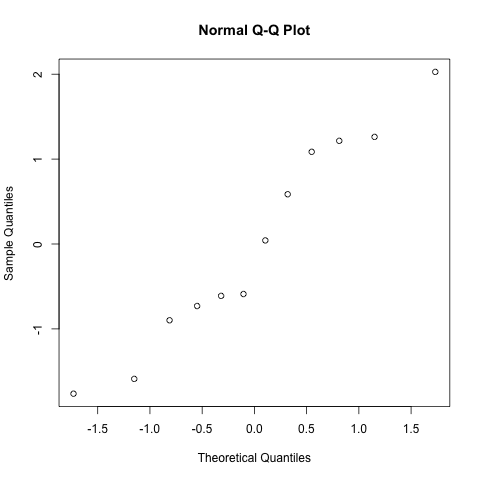

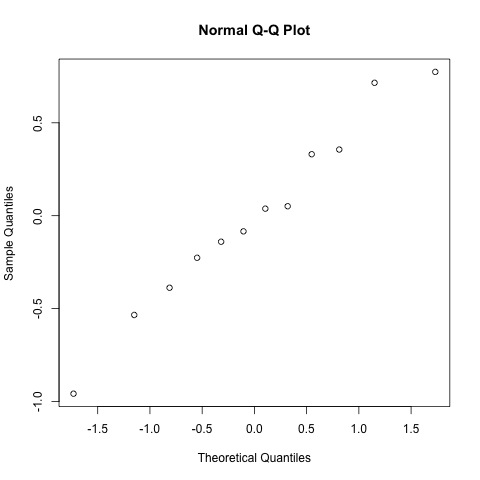

In [72]:
%%R -i df -o abc_0_5_model -o abc_10_5_model
m <- glmer('pref ~ 1 + abc_0_5*factor(day)  + (1 + abc_0_5|mouse)', data = df, weights = tot, family = 'binomial')
abc_0_5_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))

m <- glmer('pref ~ 1 + abc_10_5*factor(day)  + (1 + abc_10_5|mouse)', data = df, weights = tot, family = 'binomial')
abc_10_5_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))

In [73]:
abc_0_5_model['Significance'] = abc_0_5_model['Pr(>|z|)'].apply(check_significance)
abc_10_5_model['Significance'] = abc_10_5_model['Pr(>|z|)'].apply(check_significance)

display(abc_0_5_model, abc_10_5_model)

main_test_fig_stats.update({'i_abc_0_5_v_pref': abc_0_5_model,
                            'j_abc_10_5_v_pref': abc_10_5_model})

Estimate  Std. Error   z value      Pr(>|z|)  \
(Intercept)           1.161835    0.206876  5.616094  1.953228e-08   
abc_0_5              -0.347310    0.170475 -2.037312  4.161879e-02   
factor(day)2          0.243612    0.211221  1.153352  2.487661e-01   
abc_0_5:factor(day)2  0.499734    0.204631  2.442120  1.460128e-02   

                     Significance  
(Intercept)                  ****  
abc_0_5                         *  
factor(day)2                   ns  
abc_0_5:factor(day)2            *

Estimate  Std. Error   z value      Pr(>|z|)  \
(Intercept)            1.541961    0.157503  9.790035  1.242532e-22   
abc_10_5               0.220883    0.054363  4.063135  4.841803e-05   
factor(day)2          -0.044709    0.209406 -0.213503  8.309344e-01   
abc_10_5:factor(day)2 -0.197721    0.085130 -2.322581  2.020169e-02   

                      Significance  
(Intercept)                   ****  
abc_10_5                      ****  
factor(day)2                    ns  
abc_10_5:factor(day)2            *

In [74]:
with pd.ExcelWriter('stats/raw/testing_stats.xlsx') as writer:  
    for k,v in main_test_fig_stats.items():
        v.to_excel(writer, sheet_name=k)

### (supplemental) - within day

In [75]:
peri_test_binned = bin_peri_bout(peri_test, 1).stack().rename('df').reset_index()
peri_test_binned['bout_fraction'] = peri_test_binned.groupby(['day','cs','mouse'], group_keys=False).event.apply(lambda x: x/x.max())
day1_test_binned = peri_test_binned.loc[peri_test_binned.day==1]

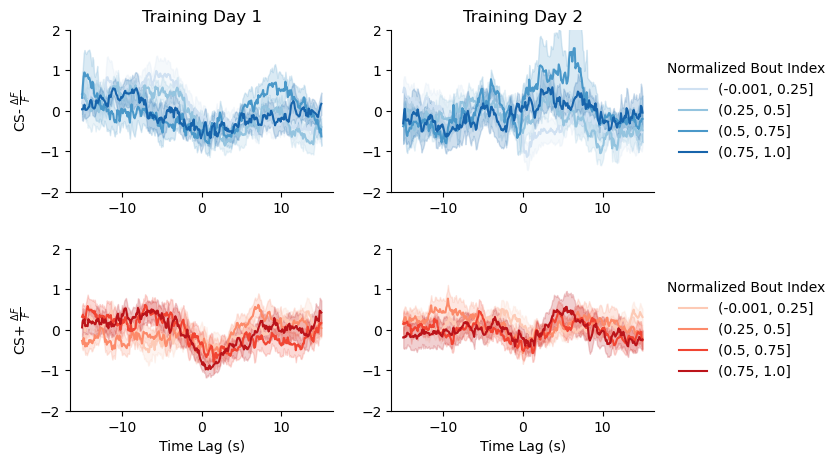

In [76]:
fig, ax = plt.subplots(2,2, figsize=(7,5))

df = peri_test.stack().rename('df').reset_index()
df['bout_fraction'] = df.groupby(['day','cs','mouse'], group_keys=False).event.apply(lambda x: x/(x.max()))
df['bout_frac_bin'] = pd.cut(df.bout_fraction, np.arange(0,1.001, 0.25), include_lowest=True)

for i in range(2):
    sns.lineplot(df.loc[(df.day==i+1) & (df.cs=='-')], x='time', y='df', hue='bout_frac_bin',
                 errorbar='se',palette='Blues', ax=ax[0,i], legend=False if i<1 else True)
    sns.lineplot(df.loc[(df.day==i+1) & (df.cs=='+')], x='time', y='df', hue='bout_frac_bin',
                 errorbar='se',palette='Reds', markeredgewidth=0, ax = ax[1,i], legend=False if i<1 else True)
    ax[0,i].set_ylim(-2,2)
    ax[1,i].set_ylim(-2,2)
    ax[0,i].set_title(f"Training Day {i+1}")
    ax[0,i].set_ylabel("")
    ax[1,i].set_ylabel("")
    ax[0,i].set_xlabel("")
    ax[1,i].set_xlabel("Time Lag (s)")

ax[0,0].set_ylabel(r"CS- $\frac{\Delta F}{F}$")
ax[1,0].set_ylabel(r"CS+ $\frac{\Delta F}{F}$")
sns.despine()
fig.tight_layout(pad=2)


ax[0,-1].legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False, title ="Normalized Bout Index")
ax[1,-1].legend(loc='center left', bbox_to_anchor=(1,0.5), frameon=False, title ="Normalized Bout Index")

fig.savefig(os.path.join(peri_stim_pdfs_test ,'supp_test_within_session.pdf'))
fig.savefig(os.path.join(peri_stim_svgs_test ,'supp_test_within_sessiont.svg'))

#### stats

R[write to console]: boundary (singular) fit: see help('isSingular')



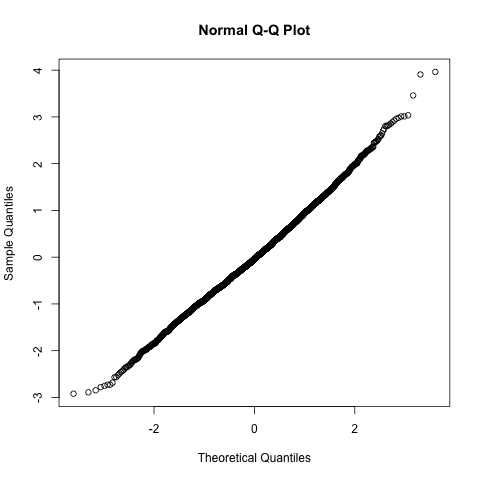

In [77]:
%%R -i day1_test_binned -o day1_test_anova -o day1_test_model
m <- lmer('df ~ 1+ bout_fraction*factor(cs)*bs(bins, df=8, degree=3) + (1 + bs(bins, df=8, degree=3)|mouse)', data=day1_test_binned)
day1_test_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
day1_test_anova <- anova(m)

In [78]:
day1_test_anova['Significance'] = day1_test_anova['Pr(>F)'].apply(check_significance)
day1_test_model['Significance'] = day1_test_model['Pr(>|t|)'].apply(check_significance)

display(day1_test_anova, day1_test_model)


supp_test_fig_peri_stats = {'day1_peri_bout_anovas': day1_test_anova,
                             'day1_peri_bout_stat':   day1_test_model}

Sum Sq    Mean Sq  \
bout_fraction                                        0.087066   0.087066   
factor(cs)                                           1.555564   1.555564   
bs(bins, df = 8, degree = 3)                        30.166149   3.770769   
bout_fraction:factor(cs)                             0.437510   0.437510   
bout_fraction:bs(bins, df = 8, degree = 3)           8.962929   1.120366   
factor(cs):bs(bins, df = 8, degree = 3)             88.950264  11.118783   
bout_fraction:factor(cs):bs(bins, df = 8, degre...  63.654223   7.956778   

                                                    NumDF        DenDF  \
bout_fraction                                           1  3137.459071   
factor(cs)                                              1  3107.977852   
bs(bins, df = 8, degree = 3)                            8    29.106879   
bout_fraction:factor(cs)                                1  3137.453917   
bout_fraction:bs(bins, df = 8, degree = 3)              8  3137.459248   
factor(cs):bs(bins, df = 8, degree = 3)                 8  3104.137534   
bout_fraction:factor(cs):bs(bins, df = 8, degre...      8  3137.458662   

                                                      F value        Pr(>F)  \
bout_fraction                                        0.097022  7.554533e-01   
factor(cs)                                           1.733447  1.880684e-01   
bs(bins, df = 8, degree = 3)                         4.201967  1.930166e-03   
bout_fraction:factor(cs)                             0.487541  4.850780e-01   
bout_fraction:bs(bins, df = 8, degree = 3)           1.248483  2.663246e-01   
factor(cs):bs(bins, df = 8, degree = 3)             12.390247  1.279275e-17   
bout_fraction:factor(cs):bs(bins, df = 8, degre...   8.866658  4.462870e-12   

                                                   Significance  
bout_fraction                                                ns  
factor(cs)                                                   ns  
bs(bins, df = 8, degree = 3)                                 **  
bout_fraction:factor(cs)                                     ns  
bout_fraction:bs(bins, df = 8, degree = 3)                   ns  
factor(cs):bs(bins, df = 8, degree = 3)                    ****  
bout_fraction:factor(cs):bs(bins, df = 8, degre...         ****

Estimate  Std. Error  \
(Intercept)                                         0.319434    0.269350   
bout_fraction                                      -0.106040    0.422692   
factor(cs)+                                        -0.433126    0.328972   
bs(bins, df = 8, degree = 3)1                       0.274663    0.526734   
bs(bins, df = 8, degree = 3)2                      -0.128201    0.416648   
bs(bins, df = 8, degree = 3)3                       1.044385    0.463225   
bs(bins, df = 8, degree = 3)4                      -1.029867    0.477972   
bs(bins, df = 8, degree = 3)5                      -0.651357    0.424074   
bs(bins, df = 8, degree = 3)6                      -0.440357    0.488460   
bs(bins, df = 8, degree = 3)7                      -1.087964    0.455510   
bs(bins, df = 8, degree = 3)8                      -0.966047    0.378521   
bout_fraction:factor(cs)+                           0.382882    0.548352   
bout_fraction:bs(bins, df = 8, degree = 3)1        -0.436740    0.863423   
bout_fraction:bs(bins, df = 8, degree = 3)2         0.315462    0.680951   
bout_fraction:bs(bins, df = 8, degree = 3)3        -1.563123    0.688535   
bout_fraction:bs(bins, df = 8, degree = 3)4         0.277643    0.617861   
bout_fraction:bs(bins, df = 8, degree = 3)5         0.141409    0.665808   
bout_fraction:bs(bins, df = 8, degree = 3)6         0.712002    0.743306   
bout_fraction:bs(bins, df = 8, degree = 3)7         0.720565    0.749716   
bout_fraction:bs(bins, df = 8, degree = 3)8         0.755966    0.596922   
factor(cs)+:bs(bins, df = 8, degree = 3)1           0.110058    0.671093   
factor(cs)+:bs(bins, df = 8, degree = 3)2          -0.278983    0.529359   
factor(cs)+:bs(bins, df = 8, degree = 3)3          -1.098839    0.535988   
factor(cs)+:bs(bins, df = 8, degree = 3)4           0.646770    0.481019   
factor(cs)+:bs(bins, df = 8, degree = 3)5           0.761744    0.517676   
factor(cs)+:bs(bins, df = 8, degree = 3)6           0.761147    0.578779   
factor(cs)+:bs(bins, df = 8, degree = 3)7           1.454078    0.582793   
factor(cs)+:bs(bins, df = 8, degree = 3)8           1.065502    0.464155   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr...  0.077264    1.120104   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -0.037006    0.883387   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr...  2.505285    0.893225   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -1.319128    0.801541   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -0.496935    0.863742   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -1.188103    0.964278   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -1.723269    0.972594   
bout_fraction:factor(cs)+:bs(bins, df = 8, degr... -0.634675    0.774377   

                                                             df   t value  \
(Intercept)                                          137.850384  1.185945   
bout_fraction                                       3137.453295 -0.250867   
factor(cs)+                                         3107.977852 -1.316604   
bs(bins, df = 8, degree = 3)1                        611.963794  0.521445   
bs(bins, df = 8, degree = 3)2                        470.411087 -0.307696   
bs(bins, df = 8, degree = 3)3                         63.088195  2.254597   
bs(bins, df = 8, degree = 3)4                         22.963729 -2.154660   
bs(bins, df = 8, degree = 3)5                        138.883731 -1.535951   
bs(bins, df = 8, degree = 3)6                         83.752716 -0.901522   
bs(bins, df = 8, degree = 3)7                        891.706976 -2.388451   
bs(bins, df = 8, degree = 3)8                        150.310055 -2.552164   
bout_fraction:factor(cs)+                           3137.453917  0.698241   
bout_fraction:bs(bins, df = 8, degree = 3)1         3137.456194 -0.505824   
bout_fraction:bs(bins, df = 8, degree = 3)2         3137.459027  0.463267   
bout_fraction:bs(bins, df = 8, degree = 3)3         3137.457472 -2.270215   
bout_fr

R[write to console]: boundary (singular) fit: see help('isSingular')



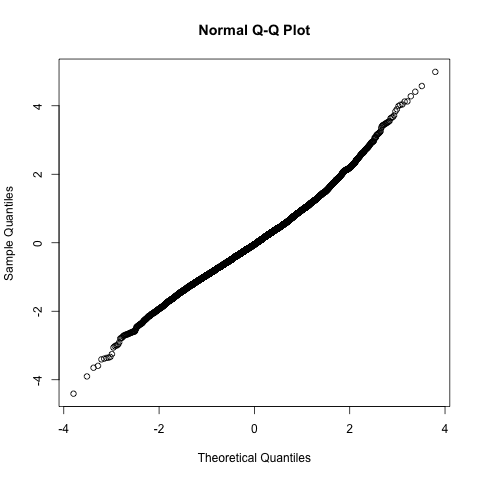

In [79]:
%%R -i peri_test_binned -o peri_within_test_anova -o peri_within_test_model
m <- lmer('df ~ 1+ factor(day)*bout_fraction*factor(cs)*bs(bins, df=8, degree=3) + (1 + bs(bins, df=8, degree=3)|mouse)', data=peri_test_binned)
peri_within_test_model <- as.data.frame(summary(m)$coefficients)
qqnorm(residuals(m))
peri_within_test_anova <- anova(m)

In [80]:
peri_within_test_anova['Significance'] = peri_within_test_anova['Pr(>F)'].apply(check_significance)
peri_within_test_model['Significance'] = peri_within_test_model['Pr(>|t|)'].apply(check_significance)


display(peri_within_test_anova, peri_within_test_model)

supp_test_fig_peri_stats.update({'peri_within_anova': peri_within_test_anova,
                                  'peri_within_model': peri_within_test_model
                                  })

Sum Sq   Mean Sq  \
factor(day)                                          0.610246  0.610246   
bout_fraction                                        1.258803  1.258803   
factor(cs)                                           0.263427  0.263427   
bs(bins, df = 8, degree = 3)                        16.341059  2.042632   
factor(day):bout_fraction                            2.378152  2.378152   
factor(day):factor(cs)                               1.186115  1.186115   
bout_fraction:factor(cs)                             0.102043  0.102043   
factor(day):bs(bins, df = 8, degree = 3)             2.764312  0.345539   
bout_fraction:bs(bins, df = 8, degree = 3)          32.042751  4.005344   
factor(cs):bs(bins, df = 8, degree = 3)             61.811759  7.726470   
factor(day):bout_fraction:factor(cs)                 0.387406  0.387406   
factor(day):bout_fraction:bs(bins, df = 8, degr...  38.811555  4.851444   
factor(day):factor(cs):bs(bins, df = 8, degree ...  42.243462  5.280433   
bout_fraction:factor(cs):bs(bins, df = 8, degre...  47.083993  5.885499   
factor(day):bout_fraction:factor(cs):bs(bins, d...  29.988941  3.748618   

                                                    NumDF        DenDF  \
factor(day)                                             1  6695.944322   
bout_fraction                                           1  6696.855717   
factor(cs)                                              1  6676.457749   
bs(bins, df = 8, degree = 3)                            8    19.971693   
factor(day):bout_fraction                               1  6696.850242   
factor(day):factor(cs)                                  1  6683.084319   
bout_fraction:factor(cs)                                1  6696.850809   
factor(day):bs(bins, df = 8, degree = 3)                8  6695.543146   
bout_fraction:bs(bins, df = 8, degree = 3)              8  6696.856399   
factor(cs):bs(bins, df = 8, degree = 3)                 8  6654.991794   
factor(day):bout_fraction:factor(cs)                    1  6696.845385   
factor(day):bout_fraction:bs(bins, df = 8, degr...      8  6696.855664   
factor(day):factor(cs):bs(bins, df = 8, degree ...      8  6669.082736   
bout_fraction:factor(cs):bs(bins, df = 8, degre...      8  6696.855886   
factor(day):bout_fraction:factor(cs):bs(bins, d...      8  6696.854955   

                                                     F value        Pr(>F)  \
factor(day)                                         0.592172  4.416076e-01   
bout_fraction                                       1.221521  2.691021e-01   
factor(cs)                                          0.255625  6.131585e-01   
bs(bins, df = 8, degree = 3)                        1.982136  1.026814e-01   
factor(day):bout_fraction                           2.307719  1.287801e-01   
factor(day):factor(cs)                              1.150986  2.833815e-01   
bout_fraction:factor(cs)                            0.099021  7.530179e-01   
factor(day):bs(bins, df = 8, degree = 3)            0.335305  9.526454e-01   
bout_fraction:bs(bins, df = 8, degree = 3)          3.886718  1.384643e-04   
factor(cs):bs(bins, df = 8, degree = 3)             7.497635  5.243448e-10   
factor(day):bout_fraction:factor(cs)                0.375932  5.398093e-01   
factor(day):bout_fraction:bs(bins, df = 8, degr...  4.707759  9.024820e-06   
factor(day):factor(cs):bs(bins, df = 8, degree ...  5.124042  2.190165e-06   
bout_fraction:factor(cs):bs(bins, df = 8, degre...  5.711188  2.888133e-07   
factor(day):bout_fraction:factor(cs):bs(bins, d...  3.637595  3.106648e-04   

                                                   Significance  
factor(day)                                                  ns  
bout_fraction                                                ns  
factor(cs)                                                   ns  
bs(bins, df = 8, degree = 3)                                 ns  
factor(day):bout_fraction                                    ns  
factor(day):factor(cs)  

Estimate  Std. Error  \
(Intercept)                                         0.327625    0.286497   
factor(day)2                                       -0.075278    0.395928   
bout_fraction                                      -0.106040    0.452964   
factor(cs)+                                        -0.391440    0.352135   
bs(bins, df = 8, degree = 3)1                       0.266478    0.571867   
...                                                      ...         ...   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,... -0.224033    1.206433   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.656942    1.300054   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.806173    1.451375   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.726995    1.463892   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,... -0.341324    1.165547   

                                                             df   t value  \
(Intercept)                                          287.120965  1.143555   
factor(day)2                                        6689.833518 -0.190131   
bout_fraction                                       6696.836422 -0.234101   
factor(cs)+                                         6686.749083 -1.111618   
bs(bins, df = 8, degree = 3)1                        616.340283  0.465979   
...                                                         ...       ...   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  6696.854584 -0.185699   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  6696.854088  0.505319   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  6696.853620  0.555455   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  6696.855461  0.496618   
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  6696.852059 -0.292845   

                                                    Pr(>|t|) Significance  
(Intercept)                                         0.253761           ns  
factor(day)2                                        0.849212           ns  
bout_fraction                                       0.814914           ns  
factor(cs)+                                         0.266342           ns  
bs(bins, df = 8, degree = 3)1                       0.641395           ns  
...                                                      ...          ...  
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.852687           ns  
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.613352           ns  
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.578602           ns  
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.619474           ns  
factor(day)2:bout_fraction:factor(cs)+:bs(bins,...  0.769650           ns  

[72 rows x 6 columns]

In [81]:
with pd.ExcelWriter('stats/raw/supp_test_peri_stats.xlsx') as writer:  
    for k,v in supp_test_fig_peri_stats.items():
        v.to_excel(writer, sheet_name=k)